load the necessary modules

In [2]:
%load_ext autoreload
%autoreload 2
import iarray as ia
import run2019
import matplotlib.pyplot as plt

In [3]:
ia.plt.rcParams['font.size'] = 15

# run2019 analysis

This notebook documents the analysis of the 2019 data. 
In the first section, the [expected rate](##-expected-rate) is discussed. 
In the second section, the [differential rate](##-differential-rate) is computed from the run 2019 data.
In the third

## expected rate

### neutrino flux

The neutrino reactor flux is
$$
\frac{d\Phi}{d E_{\nu}} = \frac{ d^3 N_{\nu} }{ d E_{\nu} d\sigma dt }
$$
with units counts/MeV/cm$^2$/s

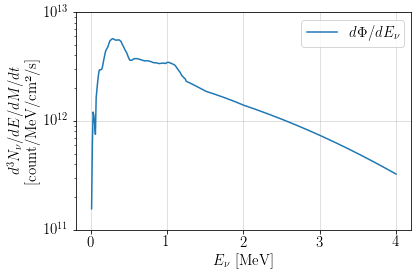

In [4]:
flux_nu = ia.genfromcsv(
    "data/reactorFlux.csv", 
    x = dict( name=r"$E_\nu$", unit=ia.MeV, dim="Enu" ), 
    y = dict( name=r"$d\Phi/d E_\nu$", unit=ia.ureg("counts/MeV/cm^2/s") ) 
)
flux_nu.xplot(ylabel=r"$d^3N_\nu/dE/dM/dt$", yscale="log")
plt.ylim((1e11, 1e13))
plt.grid(True)

![alt text](data/fluxReactor.png "the title")

In [4]:
print( flux_nu )

<xarray.DataArray '$d\\Phi/d E_\\nu$' (Enu: 400)>
<Quantity([1.55300186e+11 6.00503436e+11 1.20516768e+12 1.11701484e+12
 9.34386939e+11 7.51759038e+11 1.64258521e+12 1.97112465e+12
 2.30794992e+12 2.64851397e+12 2.92198769e+12 2.95330734e+12
 2.94983050e+12 2.96517146e+12 3.07291462e+12 3.37381601e+12
 3.65395081e+12 3.97697077e+12 4.28082371e+12 4.48887215e+12
 4.61950810e+12 4.75014404e+12 4.96186152e+12 5.21922696e+12
 5.44713539e+12 5.52522055e+12 5.60330571e+12 5.68139086e+12
 5.70284656e+12 5.64880513e+12 5.59476369e+12 5.54072225e+12
 5.52901080e+12 5.53527709e+12 5.54154338e+12 5.54780966e+12
 5.55407595e+12 5.49767185e+12 5.41842799e+12 5.30341781e+12
 5.08069372e+12 4.93916689e+12 4.77320209e+12 4.61211644e+12
 4.46827118e+12 4.34018525e+12 4.22987843e+12 4.04930827e+12
 3.87849229e+12 3.74236159e+12 3.61679297e+12 3.60926581e+12
 3.60173865e+12 3.62459352e+12 3.66521013e+12 3.69833076e+12
 3.73145140e+12 3.73592981e+12 3.73563285e+12 3.73533589e+12
 3.73282561e+12 3.7155553

<xarray.DataArray (Enu: 3)>
<Quantity([1.14725030e+12 1.14728487e+12 1.14731951e+12], 'count / centimeter ** 2 / megaelectron_volt / second')>
Coordinates:
    $E_\nu$  (Enu) float64 [MeV] 3.98 3.99 4.0
Dimensions without coordinates: Enu


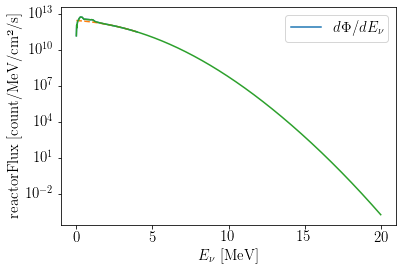

In [21]:
def flux_fit(E, N=1.14732e12):
    fit = lambda E, a, a0, a1, a2: a*ia.np.exp(a0 + a1*E/ia.MeV + a2*(E/ia.MeV)**2)
    flux_U235 = lambda E: fit(E, 1.0461, 0.870, -0.160, -0.091)
    flux_Pu239 = lambda E: fit(E, 1.0527, 0.896, -0.239, -0.0981)
    flux_U238 = lambda E: fit(E, 1.0719, 0.976, -0.162, -0.079)
    flux_Pu241 = lambda E: fit(E, 1.0818, 0.793, -0.080, -0.1085)
    return N*(.55*flux_U235(E) + .32*flux_Pu239(E) + .07*flux_U238(E) + .06*flux_Pu241(E)) # * ia.ureg("count/MeV/cm^2/s")

print( flux_nu[-3:]/flux_fit(flux_nu[r"$E_\nu$"][-3:], N=1) )
E_nu = ia.xr.DataArray( 
    name = r"$E_\nu$",
    data = ia.np.arange(.01, 20, .01) * ia.MeV,
    dims = "Enu"
)
reactor_flux = ia.xr.DataArray(
    name = r"reactorFlux",
    data = ia.np.concatenate( 
        [
            flux_nu.pint.magnitude, 
            flux_fit(E_nu[ E_nu > flux_nu[r"$E_\nu$"][-1] ]).data.magnitude
        ], 
        axis=0 ) * flux_nu.pint.units,
    dims = flux_nu.dims,
    coords = {r"$E_\nu$": E_nu}
)
flux_nu.xplot(ylabel="$d^3N_\nu/dE/dM/dt$")
plt.plot( flux_nu[r"$E_\nu$"].pint.magnitude, flux_fit(flux_nu[r"$E_\nu$"]).pint.magnitude, "--" )
reactor_flux.xplot()
plt.yscale("log")

In [6]:
print( reactor_flux )

<xarray.DataArray 'reactorFlux' (Enu: 999)>
<Quantity([1.55300186e+11 6.00503436e+11 1.20516768e+12 1.11701484e+12
 9.34386939e+11 7.51759038e+11 1.64258521e+12 1.97112465e+12
 2.30794992e+12 2.64851397e+12 2.92198769e+12 2.95330734e+12
 2.94983050e+12 2.96517146e+12 3.07291462e+12 3.37381601e+12
 3.65395081e+12 3.97697077e+12 4.28082371e+12 4.48887215e+12
 4.61950810e+12 4.75014404e+12 4.96186152e+12 5.21922696e+12
 5.44713539e+12 5.52522055e+12 5.60330571e+12 5.68139086e+12
 5.70284656e+12 5.64880513e+12 5.59476369e+12 5.54072225e+12
 5.52901080e+12 5.53527709e+12 5.54154338e+12 5.54780966e+12
 5.55407595e+12 5.49767185e+12 5.41842799e+12 5.30341781e+12
 5.08069372e+12 4.93916689e+12 4.77320209e+12 4.61211644e+12
 4.46827118e+12 4.34018525e+12 4.22987843e+12 4.04930827e+12
 3.87849229e+12 3.74236159e+12 3.61679297e+12 3.60926581e+12
 3.60173865e+12 3.62459352e+12 3.66521013e+12 3.69833076e+12
 3.73145140e+12 3.73592981e+12 3.73563285e+12 3.73533589e+12
 3.73282561e+12 3.71555533e+12 

### cross section

The Standard Model CEvNS cross section is
$$
\frac{ d\sigma }{d E_{\rm R}} = \frac{G_F^2}{4\pi} Q_W^2 \left(
    1 - \frac{E_R}{E_\nu} + (E_R - M)\frac{E_R}{2E_\nu^2}
\right) M F^2
$$
where
$$
G_F = 1.1663787 \cdot 10^{-5} \text{GeV}^{-2}\quad \text{Fermi constant}
\\
Q_W = N = 14 \quad \text{weak nuclear charge}
\\
M = 28.085 \text{u} = 28.085 \cdot 9.314 \cdot 10^5 \text{keV}\quad \text{Silicon atomic mass}
\\
F = 1 \quad \text{nuclear form factor}
$$

In [195]:
E_R = ia.Coord(r"$E_{\rm R}$", "Er", ia.arange(0,5,.001)*ia.keV )
# print( E_R )
# print( flux_nu.xcoords[0] )

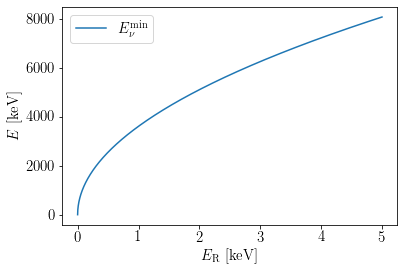

In [196]:
def E_nu_min(ER):
    M = run2019.M_Si_amu * ia.amu
    return ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )

E_nu_min( E_R ).xplot( ylabel=r"$E$" )

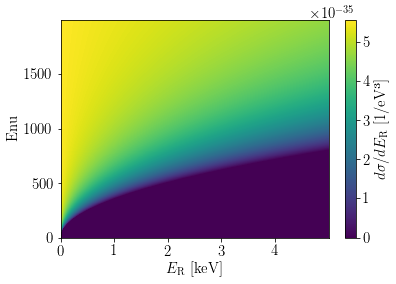

In [197]:
def dsigma__dE_R( ER, Enu ):
    M = run2019.M_Si_amu * ia.amu
    Enu_min = ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )
    F = 1
    QW = 14
    GF = 1.1663787e-5 / ia.GeV**2.
    data = GF**2./(4*ia.pi) * QW**2. * ( 1 - ER/Enu + ER*(ER - M)/2/Enu**2. ) * M * F**2.
    return ia.Array( r"$d\sigma/dE_{\rm R}$", data = data ).where( Enu > Enu_min, 0 )

dsigma__dE_R(E_R, E_nu).xplot()

### recoil rate

The rate of recoil events is obtained by convoluting the neutrino flux with the cross section and multiplying by the number of Silicon nuclei per kg
$$
\frac{dR}{d E_R} = N_T \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d\Phi}{dE_\nu} \frac{d\sigma}{dE_R}
$$
which can be expressed as
$$
\frac{d^3N}{d E_R dM dt} = \frac{dN_T}{dM} \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d^3 N}{dE_\nu d\sigma dt} \frac{d\sigma}{dE_R}
$$
where
$$
E_\nu^\text{min} = \frac{1}{2} \left( E_R + \sqrt{ E_R^2 + 2ME_R } \right)
\\
\frac{dN_T}{dM} = \frac{6.022 \cdot 10^{23} }{28.084 \cdot 10^{-3} \text{kg}}
$$

However, the differential cross section is at natural units, while the neutrino flux is in SI. 
In order to make them compatible, the quantities are converted to barn.
$$
\text{SI:}\quad \text{cm}^2 = 10^{27}\text{mb}
\\
\text{natural:}\quad \text{GeV}^{-2} = \frac{1}{2.56819} \text{mb}
$$
dividing both gives
$$
\text{cm}^2\text{GeV}^2 = 2.56819 \cdot 10^{27}
$$

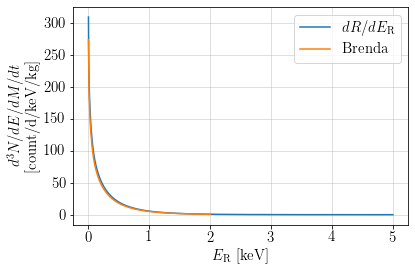

In [198]:
def dR__dE_R( E_R, flux_nu ):
    to_barn = ia.ureg( "cm^2.*GeV^2." )/2.568e27
    N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
    return ia.Array(
        r"$dR/dE_{\rm R}$",
        data = ( N_T * flux_nu * dsigma__dE_R( E_R, flux_nu.xcoords[0] ) * to_barn)
    ).integrate( flux_nu.xcoords[0].name ).pint.to("count/keV/kg/day")

# ia.print_table(dR__dE_R( E_R, flux_nu ), x=r"$E_{\rm R}$", out="data/recoilRate.csv")
# dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
dR__dE_R( E_R, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEr.csv", delimiter=",").T, label="Brenda" )
plt.legend()
plt.grid(True)

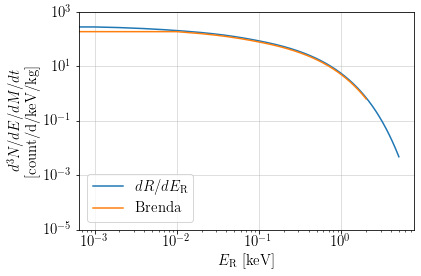

In [199]:
dR__dE_R( E_R, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", xscale="log", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEr.csv", delimiter=",").T, label="Brenda" )
plt.legend()
plt.ylim((1e-5,1e3))
plt.grid(True)

![alt text](data/paperQuenching.png "the title")

Figure 4. Left: The expected recoil energy spectrum (blue dashed line); the visible energy spectrum
assuming a Lindhard Q factor (red solid line); the visible energy spectrum with Lindhard Q factor and
the effect of the detector efficiency (green dashed line). Right: Total event rate as a function of the
energy threshold for various quenching factors. The shaded area shows the expected signal region for a
threshold of 5σRMS ' 28 eV, and realistic quenching factors. Adapted from [9].

from: 1608.01565.pdf

### quenching factor

The quenching factor is defined as the fraction of the Silicon recoil energy which is converted to electron ionization energy,
$$
E_I = Q E_R
$$

To convertion from recoil energy to ionization energy,
$$
E_R \rightarrow E_I = Q E_R
$$
furtheremore,
$$
\frac{df(E_R)}{dE_R} \rightarrow \frac{df(E_R)}{d(Q E_R)}
= \frac{dE_R}{d(Q E_R)} \frac{df(E_R)}{dE_R} 
$$

In the case the quenching factor is defined as a function of the ionization energy $Q = Q(E_I)$,
$$
\frac{dE_R}{dE_I} = \frac{d}{dE_I}\left(\frac{E_I}{Q(E_I)}\right)
= \left( \frac{1}{Q(E_I)} - \frac{E_I}{Q(E_I)^2} \frac{dQ(E_I)}{dE_I} \right)
$$


In [288]:
E_I = ia.Coord(r"$E_{\rm I}$", "Ei", ia.arange(.001, 5, .001)*ia.keV )
print( E_I )
def Q(E_I):
    p0 = 56 * ia.keV**3.
    p1 = 1096 * ia.keV**2
    p2 = 382 * ia.keV
    p3 = 168 * ia.keV**2
    p4 = 155 * ia.keV
    N = p3*E_I + p4*E_I**2 + E_I**3
    D = p0 + p1*E_I + p2*E_I**2
    return ia.Array( r"$Q(E_{\rm I})$", data = N/D )

Chavarria = Q(E_I)
Chavarria.name = "Chavarria"
Chavarria[r"$E_{\rm R}$"] = E_I/Chavarria 
print( Chavarria )

<xarray.DataArray '$E_{\\rm I}$' (Ei: 4999)>
<Quantity([1.000e-03 2.000e-03 3.000e-03 ... 4.997e+00 4.998e+00 4.999e+00], 'kiloelectron_volt')>
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.001 0.002 0.003 ... 4.997 4.998 4.999
Dimensions without coordinates: Ei
<xarray.DataArray 'Chavarria' (Ei: 4999)>
<Quantity([0.00294511 0.00578449 0.00852391 ... 0.32078433 0.32079864 0.32081295], 'dimensionless')>
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.001 0.002 0.003 ... 4.997 4.998 4.999
    $E_{\rm R}$  (Ei) float64 [keV] 0.3395 0.3458 0.352 ... 15.58 15.58 15.58
Dimensions without coordinates: Ei


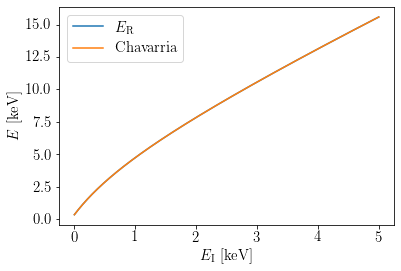

In [226]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot( x = r"$E_{\rm I}$", ylabel="$E$")
plt.plot( 
    Chavarria[r"$E_{\rm I}$"].pint.magnitude, 
    Chavarria[r"$E_{\rm R}$"].pint.magnitude, 
    label = "Chavarria"
)
plt.legend()

(0.05, 20)

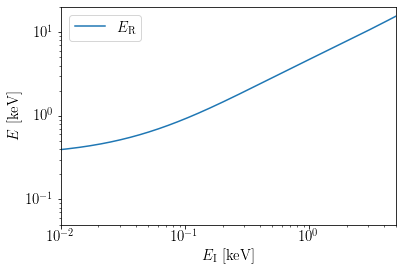

In [227]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot(ylabel="$E$", xscale="log", yscale="log")

plt.xlim((1e-2, 5))
plt.ylim((0.05, 20))

![alt text](data/quenchingParametrized.png "the title")

### ionization rate

the ionization energy is obtained by computing the conversion factor between the Silicon recoil energy and the electron ionization energy
$$
\frac{dE_R}{dE_I}(E_I) = \frac{1}{Q(E_I)^2}\left( Q(E_I) - E_I \frac{dQ}{dE_I}(E_I) \right)
$$

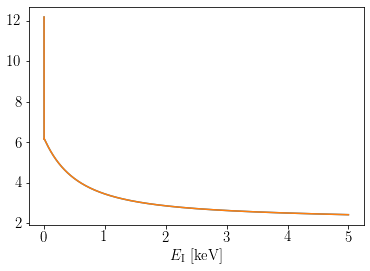

In [228]:
def dE_R__dE_I(E_I, Q):
    return ia.Array(
        r"$dE_{\rm R}/dE_{\rm I}$",
        data = 1./Q(E_I) - E_I/Q(E_I)**2 * Q(E_I).xdiff()
    )

dE_R__dE_I(E_I, Q).xplot()
(1./Chavarria - Chavarria[r"$E_{\rm I}$"]/Chavarria**2 * Chavarria.xdiff(r"$E_{\rm I}$")).xplot(x=r"$E_{\rm I}$")

the ionization rate is then
$$
\frac{dR}{dE_I}(E_I) = \frac{dE_R}{dE_I}(E_I) \frac{dR}{dE_R}(E_I)
$$

<xarray.DataArray '$dR/dE_{\\rm R}$' ()>
<Quantity(4.515536991163989, 'count / day / kilogram')>
Coordinates:
    $E_{\rm I}$  float64 [keV] 0.002
<xarray.DataArray '$dR/dE_{\\rm I}$' ()>
<Quantity(4.538434343020632, 'count / day / kilogram')>


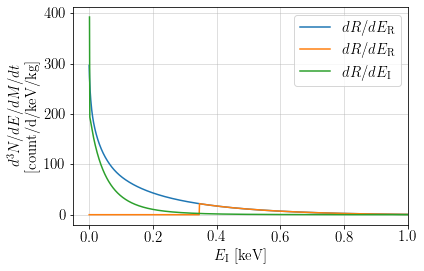

In [229]:
def dR__dE_I(E_I, Q, flux_nu):
    return ia.Array(
        r"$dR/dE_{\rm I}$",
        data = dR__dE_R(E_I/Q(E_I), flux_nu) * dE_R__dE_I(E_I, Q)
    )

print( dR__dE_R( E_R, flux_nu ).where( E_R > E_I[1]/Q(E_I[1]), 0 ).integrate(E_R.name) )
print( dR__dE_I( E_I[1:], Q, flux_nu ).integrate(E_I.name) )

dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

dR__dE_R( E_R, flux_nu ).where(E_R > E_I[1]/Q(E_I[1]), 0).xplot(x=E_R.name, ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

# dR__dE_I( E_I, Q, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
dR__dE_I( E_I, Q, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
plt.xlim( (-.05,1) )
plt.grid(True)

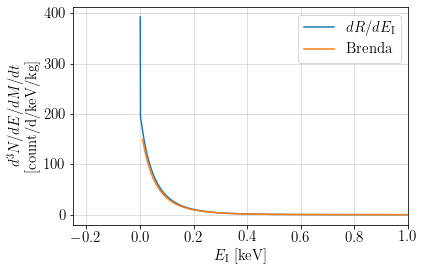

In [230]:
# dR__dE_I( E_I, Q, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
dR__dE_I( E_I, Q, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEi.csv", delimiter=", ").T, label="Brenda" )
plt.legend()
plt.xlim( (None,1) )
plt.grid(True)

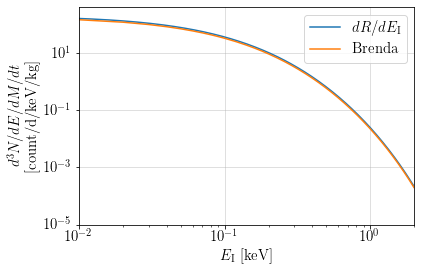

In [231]:
# dR__dE_I( E_I, Q, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day", yscale="log")
dR__dE_I( E_I, Q, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEi.csv", delimiter=", ").T, label="Brenda" )
plt.legend()
plt.xlim( (1e-2,2) )
plt.ylim( (1e-5,None) )
plt.grid(True)
plt.yscale("log")
plt.xscale("log")

The comparison between the Silicon recoil and the electron ionization rates show that the rate is higher for the ionization

(1e-05, 10000.0)

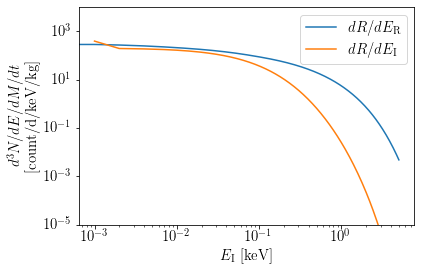

In [232]:
# dR__dE_R( E_R, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
dR__dE_R( E_R, reactor_flux ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
# dR__dE_I( E_I, Q, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
dR__dE_I( E_I, Q, reactor_flux ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
plt.ylim( (1e-5,1e4) )

![alt text](data/paperQuenching.png "the title")

Figure 4. Left: The expected recoil energy spectrum (blue dashed line); the visible energy spectrum
assuming a Lindhard Q factor (red solid line); the visible energy spectrum with Lindhard Q factor and
the effect of the detector efficiency (green dashed line). Right: Total event rate as a function of the
energy threshold for various quenching factors. The shaded area shows the expected signal region for a
threshold of 5σRMS ' 28 eV, and realistic quenching factors. Adapted from [9].

from: 1608.01565.pdf

In [233]:
print( dR__dE_R( (Q(E_I)*E_I)[1:], flux_nu ).integrate(E_I.name) )
print( dR__dE_I( E_I[1:], Q, flux_nu ).integrate(E_I.name) )

<xarray.DataArray '$dR/dE_{\\rm R}$' ()>
<Quantity(131.2110213868111, 'count / day / kilogram')>
<xarray.DataArray '$dR/dE_{\\rm I}$' ()>
<Quantity(4.538434343020632, 'count / day / kilogram')>


### Lindhard quenching

The Lindhard quenching factor is derived from first principles.
Therefore, it gives a dependence of the quenching factor with the recoil energy and not the ionization energy.

$$
Q(E_R) = \frac{c_z E_R - \nu(c_z E_R) }{c_z E_R} 
= \frac{1}{c_z E_R}\left( c_z E_R - \frac{c_z E_R}{1 + k g(c_z E_R)} \right)
\\
= 1 - \frac{1}{1 + k g(c_z E_R)}
$$

where, $c_z = 11.5/Z^{7/3}/$keV, $k=0.133Z^{2/3}/A^{1/2}$ and 
$$
g(\epsilon) = 3 \epsilon^{0.15} + 0.7 \epsilon^{0.6} + \epsilon
$$

for Silicon $A=28$, $Z=14$

<xarray.DataArray 'Lindhard' (Er: 5000)>
<Quantity([-0.          0.08188478  0.09011016 ...  0.26791958  0.26792848
  0.26793738], 'dimensionless')>
Coordinates:
    $E_{\rm R}$  (Er) float64 [keV] 0.0 0.001 0.002 0.003 ... 4.997 4.998 4.999
    $E_{\rm I}$  (Er) float64 [keV] -0.0 8.188e-05 0.0001802 ... 1.339 1.339
Dimensions without coordinates: Er


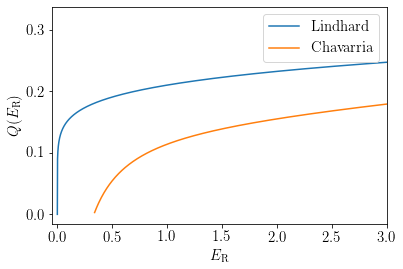

In [234]:
def Lindhard_Q(E_R):
    A = 28
    Z = 14
    c_z = 11.5/Z**(7/3)/ia.keV
    k = 0.133*Z**(2/3)/A**.5
    g = lambda e: 3*e**.15 + .7*e**.6 + e
    return 1 - 1/(1+k*g(c_z*E_R))

Q_L = Lindhard_Q(E_R)
Q_L.name = "Lindhard"
Q_L[r"$E_{\rm I}$"] = E_R * Q_L
print( Q_L )
plt.plot( E_R.pint.magnitude, Q_L.pint.magnitude, label = "Lindhard" )
plt.plot( (E_I/Q(E_I)).pint.magnitude, Q(E_I).pint.magnitude, label = "Chavarria" )
plt.xlabel(r"$E_{\rm R}$")
plt.ylabel(r"$Q(E_{\rm R})$")
plt.xlim((-.05,3))
plt.legend();

### Sarkis quenching

$$
Q(E_R) = \frac{c_z (E_R + U) - \nu(c_z E_R) }{c_z (E_R + U)} 
= \frac{1}{c_z (E_R + U)}\left( c_z (E_R + U) - \frac{c_z E_R}{1 + k g(c_z E_R)} \right)
\\
= 1 - \frac{E_R}{E_R + U}\frac{1}{1 + k g(c_z E_R)}
$$

where, $c_z = 11.5/Z^{7/3}/$keV, $k=0.133Z^{2/3}/A^{1/2}$ and 
$$
g(\epsilon) = 3 \epsilon^{0.15} + 0.7 \epsilon^{0.6} + \epsilon
$$

for Silicon $A=28$, $Z=14$

In [235]:
Sarkis_PRD = ia.genfromcsv(
    "data/SarkisPRD.csv", 
    x = {"name": r"$E_{\rm R}$", "unit": ia.keV}, 
    y = {"unit": 1},
)
Sarkis_AN = ia.genfromcsv(
    "data/SarkisAtNucl.csv", 
    x = {"name": r"$E_{\rm R}$", "unit": ia.keV}, 
    y = {"unit": 1},
)
Sarkis_PRD.name = "SarkisPRD"
Sarkis_PRD[r"$E_{\rm I}$"] = Sarkis_PRD * Sarkis_PRD[r"$E_{\rm R}$"]

Sarkis_AN.name = "SarkisAN"
uniqueE, idxE = ia.unique( Sarkis_AN[r"$E_{\rm R}$"].pint.magnitude, return_index=True )
Sarkis_AN = Sarkis_AN[idxE]
Sarkis_AN[r"$E_{\rm I}$"] = Sarkis_AN * Sarkis_AN[r"$E_{\rm R}$"]

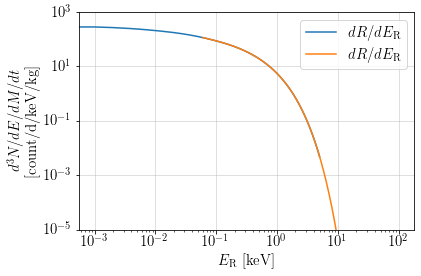

In [236]:
dR__dE_R( E_R, reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", xscale="log", unit="count/keV/kg/day")
dR__dE_R( Sarkis_AN[r"$E_{\rm R}$"], reactor_flux ).xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", xscale="log", unit="count/keV/kg/day")
plt.legend()
plt.ylim((1e-5,1e3))
plt.grid(True)

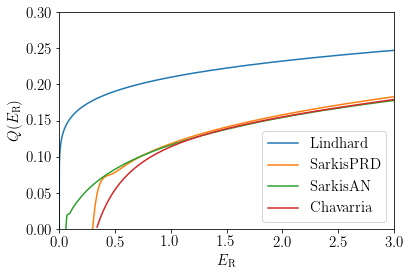

In [237]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm R}$"].pint.magnitude,
        quenching.pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 0, 3 ))
plt.ylim(( 0, .3 ))
plt.xlabel(r"$E_{\rm R}$")
plt.ylabel(r"$Q(E_{\rm R})$")
plt.legend();

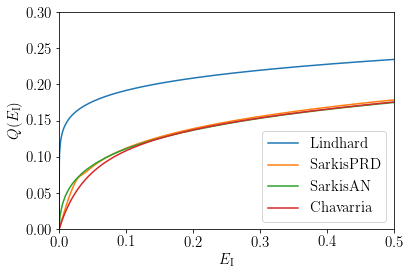

In [238]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        quenching.pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 0, .5 ))
plt.ylim(( 0, .3 ))
plt.xlabel(r"$E_{\rm I}$")
plt.ylabel(r"$Q(E_{\rm I})$")
plt.legend();

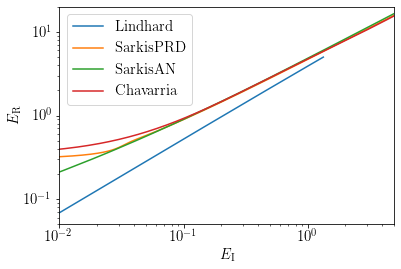

In [239]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        quenching.coords[r"$E_{\rm R}$"].pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 1e-2, 5 ))
plt.ylim(( 5e-2, 20 ))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_{\rm I}$")
plt.ylabel(r"$E_{\rm R}$")
plt.legend();

![alt text](data/quenchingParametrized.png "the title")

inverting the quenching factor so that it depends on the ionization energy

$$
E_I = Q(E_R) E_R
$$


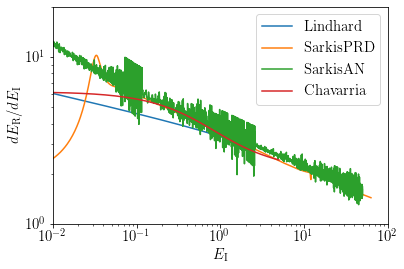

In [241]:
def dE_R__dE_I_from_R(Q):
    data = 1/Q - Q[r"$E_{\rm I}$"]/Q**2 * Q.xdiff(r"$E_{\rm I}$")
    return data

for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        dE_R__dE_I_from_R(quenching).pint.magnitude,
        label = quenching.name
    )

plt.xlabel( r"$E_{\rm I}$" )
plt.ylabel( r"$dE_{\rm R}/dE_{\rm I}$" )
plt.xlim((1e-2,1e2))
plt.ylim((1, 20))
plt.yscale("log")
plt.xscale("log")
plt.legend();

In [ ]:
plt.plot(
    Sarkis_AN[r"$E_{\rm I}$"].pint.magnitude, 
    Sarkis_AN[r"$dE_{\rm R}/dE_{\rm I}$"].pint.magnitude,
    label = Sarkis_AN.name
)


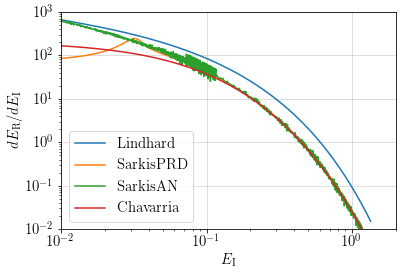

In [243]:
def dR__dE_I_from_R(Q, flux_nu):
    data = dR__dE_R( Q[r"$E_{\rm R}$"], flux_nu) * dE_R__dE_I_from_R(Q)
    data["name"] = r"$dR/dE_{\rm I}$"
    return data

for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        dR__dE_I_from_R(quenching, reactor_flux).pint.magnitude,
        label = quenching.name
    )

plt.xlabel( r"$E_{\rm I}$" )
plt.ylabel( r"$dE_{\rm R}/dE_{\rm I}$" )
plt.legend();

plt.ylim( (1e-2, 1e3) )
plt.xlim( (1e-2,2) )
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

<xarray.Dataset>
Dimensions:      (E: 999)
Coordinates:
    $E_{\rm I}$  (E) float64 0.001 0.002 0.003 0.004 ... 0.996 0.997 0.998 0.999
  * E            (E) float64 0.001 0.002 0.003 0.004 ... 0.996 0.997 0.998 0.999
Data variables:
    Lindhard     (E) float64 1.706e+03 1.364e+03 1.174e+03 ... 0.09235 0.09184
    SarkisPRD    (E) float64 69.75 70.86 72.13 73.49 ... 0.02728 0.02713 0.02697
    SarkisAN     (E) float64 970.3 3.558e+03 1.372e+03 ... 0.02647 0.02719
    Chavarria    (E) float64 392.5 193.9 190.4 186.6 ... 0.02513 0.02499 0.02485


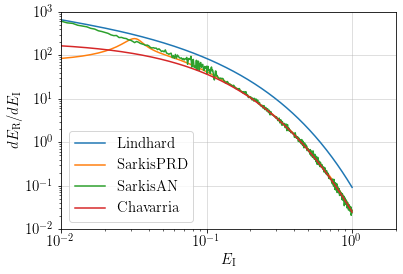

In [265]:
def dR__dE_I_from_R(Q, flux_nu):
    data = dR__dE_R( Q[r"$E_{\rm R}$"], flux_nu) * dE_R__dE_I_from_R(Q)
    data.name = r"$dR/dE_{\rm I}$"
    return data

quenchingFactors = ia.xr.Dataset()
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    this = dR__dE_I_from_R(quenching, reactor_flux)
    this = this.rename({this.dims[0]: "E"})
    this["E"] = this[r"$E_{\rm I}$"].pint.magnitude
    this = this.pint.dequantify().interp( coords = {this.dims[0]: ia.arange(1e-3, 1, 1e-3) } )
#     print( this )
    quenchingFactors[ quenching.name ] = this
    plt.plot(
        this.coords[r"$E_{\rm I}$"].pint.magnitude,
        this.pint.magnitude, #.interp(coord={}),
        label = quenching.name
    )
del quenchingFactors[r"$E_{\rm R}$"]
print( quenchingFactors )
plt.xlabel( r"$E_{\rm I}$" )
plt.ylabel( r"$dE_{\rm R}/dE_{\rm I}$" )
plt.legend();

plt.ylim( (1e-2, 1e3) )
plt.xlim( (1e-2,2) )
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

## acceptance

The acceptance is computed  by simulating events with given ionization energies and confirming the rate of reconstruction
$$
\frac{dN}{dE_I} = {\cal A}(E_{\rm I})\frac{dN_S}{dE_I},
$$

### simulation spectrum

In [295]:
E_I = quenchingFactors[r"$E_{\rm I}$"]
E_I.name = ""
E_I = E_I.pint.quantify()
E_I.name = r"$E_{\rm I}$"
del E_I["E"]
del E_I[r"$E_{\rm I}$"]
print(E_I)

<xarray.DataArray '$E_{\\rm I}$' (E: 999)>
<Quantity([0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036
 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048
 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059 0.06
 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071 0.072
 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083 0.084
 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095 0.096
 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107 0.108
 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119 0.12
 0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131 0.132
 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143 0.144
 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155 0.156


ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


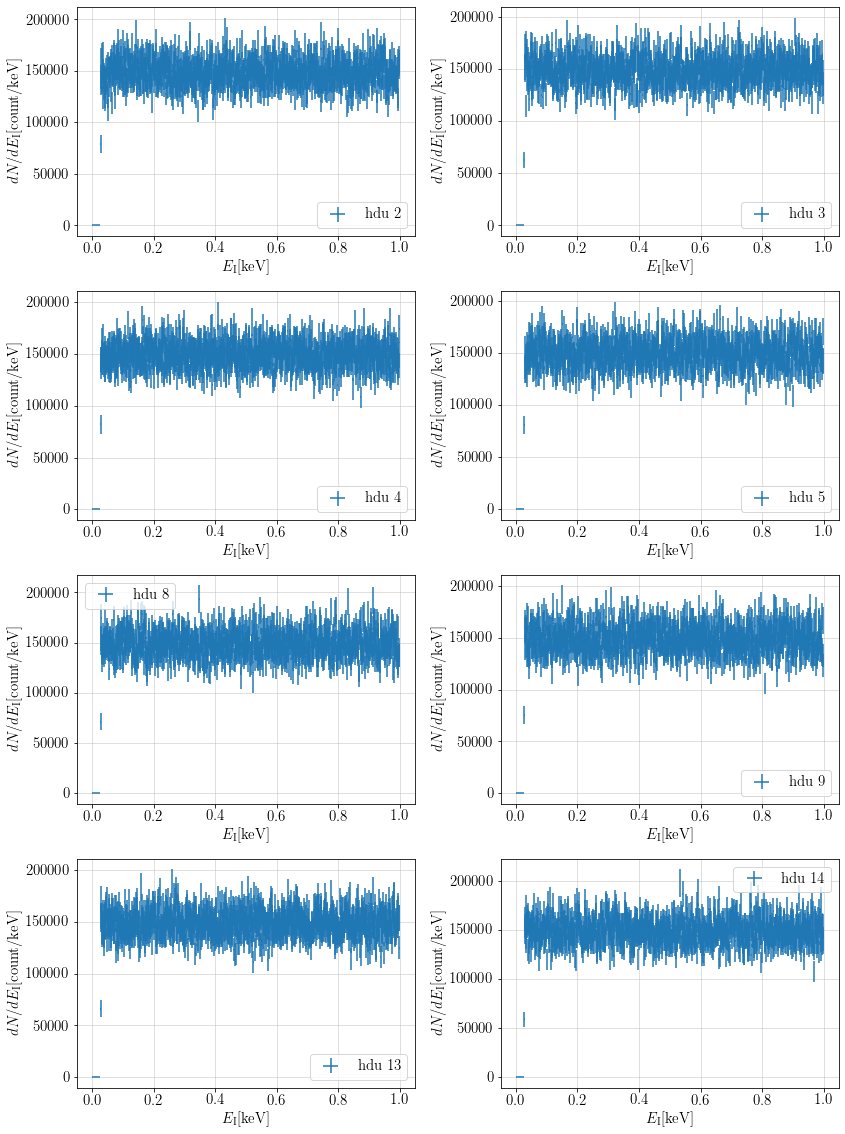

In [324]:
import iarray as ia
def dNsim__dE_I( E_I, cut ):
    data = ia.genfromroot( 
        run2019.sim_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "hdu"},
        cut = str(cut*run2019.excluded_hdu),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

dNsim__dE_I( E_I, run2019.on_excl ).xerrorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### matched spectrum

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


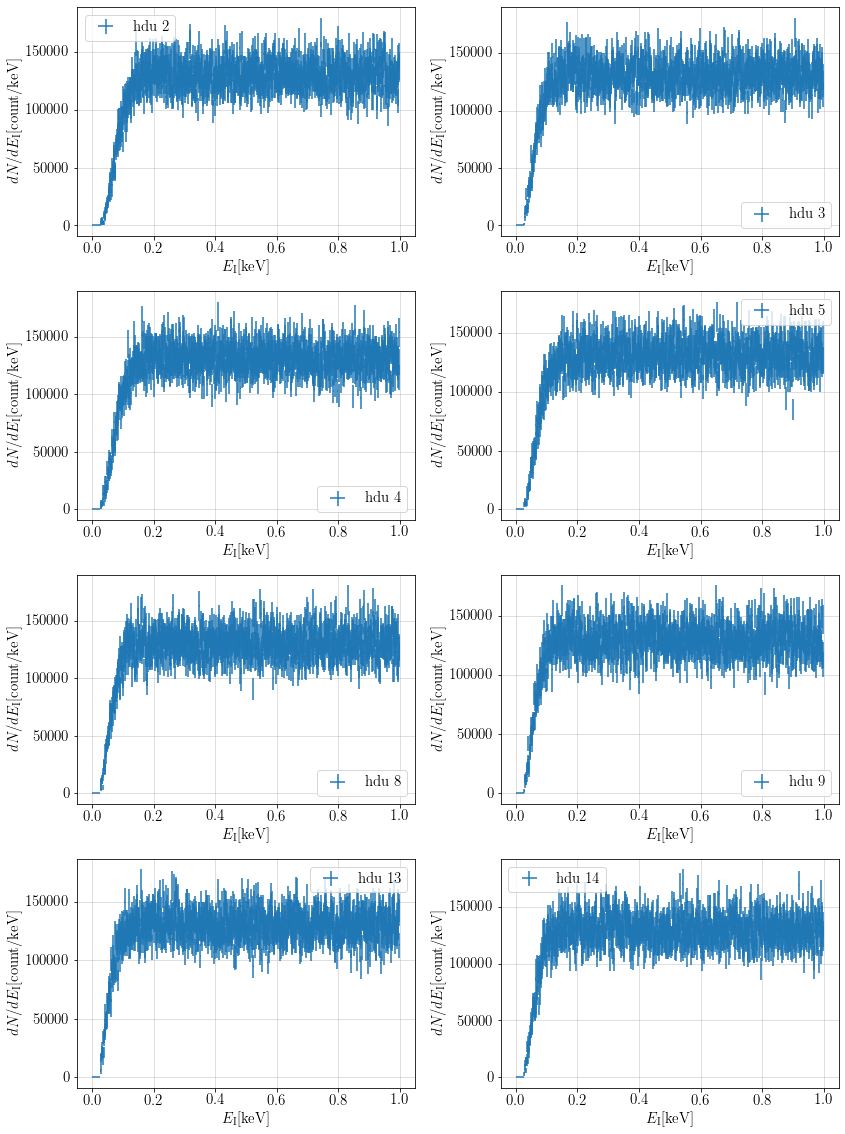

In [297]:
def dNmatch__dE_I( E_I, cut, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

dNmatch__dE_I( E_I, run2019.on_excl ).xerrorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### acceptance per hdu

<xarray.Dataset>
Dimensions:          (E: 997, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (E) float64 [keV] 0.002 0.003 0.004 ... 0.996 0.997 0.998
Dimensions without coordinates: E
Data variables:
    $dN/dE_{\rm I}$  (hdu, E) object [count/keV] 0.0+/-0 ... (1.41+/-0.12)e+05
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


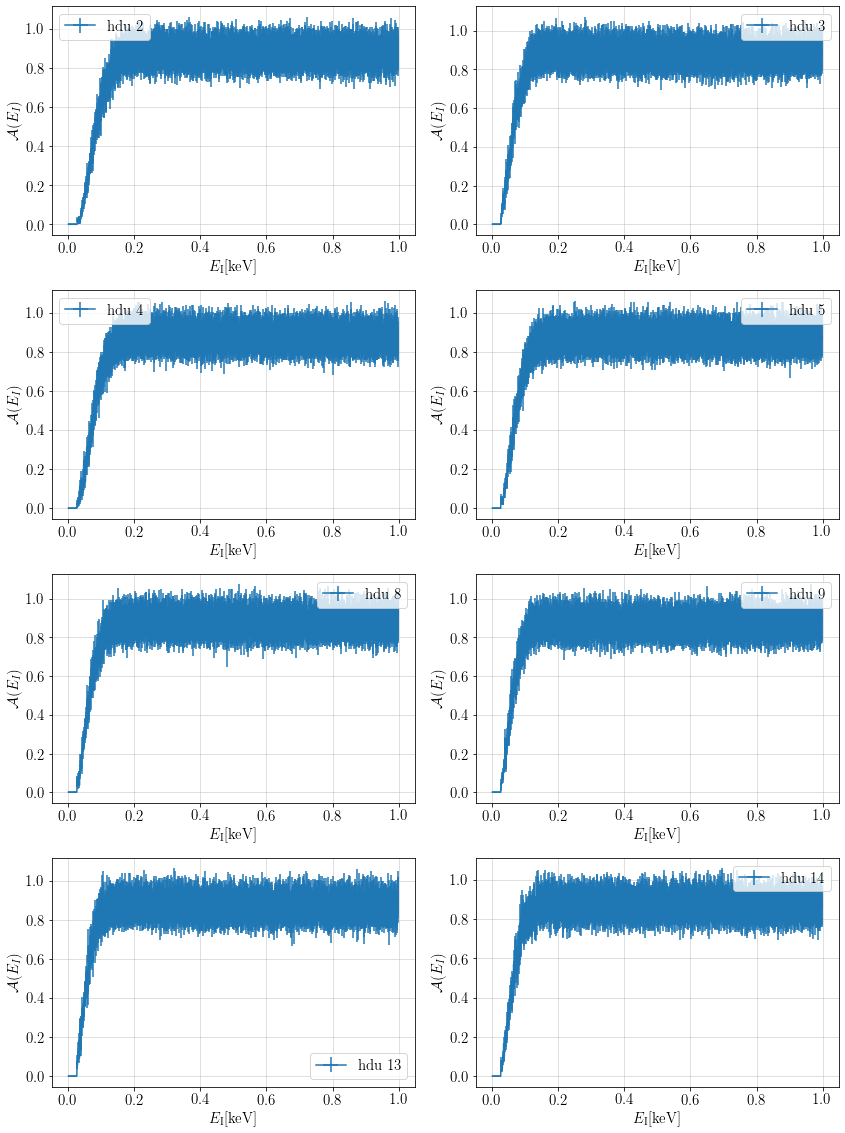

In [298]:
def Acceptance(E_I, cut):
    sim = dNsim__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    match = dNmatch__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    sim_where = sim.where(sim.pint.magnitude>0, 1*sim.pint.units)
    match_where = match.where(sim.pint.magnitude>0, 0*sim.pint.units)
    return ia.xr.Dataset(
        data_vars = {r"$\mathcal{A}(E_I)$": match_where/sim_where }
    )

Acceptance(E_I, run2019.on_excl).xerrorbar(x=r"$E_{\rm I}$", y=r"$\mathcal{A}(E_I)$", z="hdu", cols_wrap=2);

### acceptance fit

fitting function
$$
p_{2} \left(
    \frac{1}{2}\tanh\left( 
        \frac{x-p_1}{p_0}
    \right) + \frac{1}{2}
\right)^{10}
=
p_{2} \text{step}( x-p_1, p_0 )^{10}
$$

In [299]:
step = lambda x, p: ia.np.tanh(x/p)/2 + 1/2
tanhFit = lambda x, *p, step=step: p[2]*step(x - p[1], p[0])**10
tanhFit_str = "p[2]*step(x - p[1], p[0] )**10"

<xarray.Dataset>
Dimensions:          (E: 997, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (E) float64 [keV] 0.002 0.003 0.004 ... 0.996 0.997 0.998
Dimensions without coordinates: E
Data variables:
    $dN/dE_{\rm I}$  (hdu, E) object [count/keV] 0.0+/-0 ... (1.41+/-0.12)e+05
da_errorbar


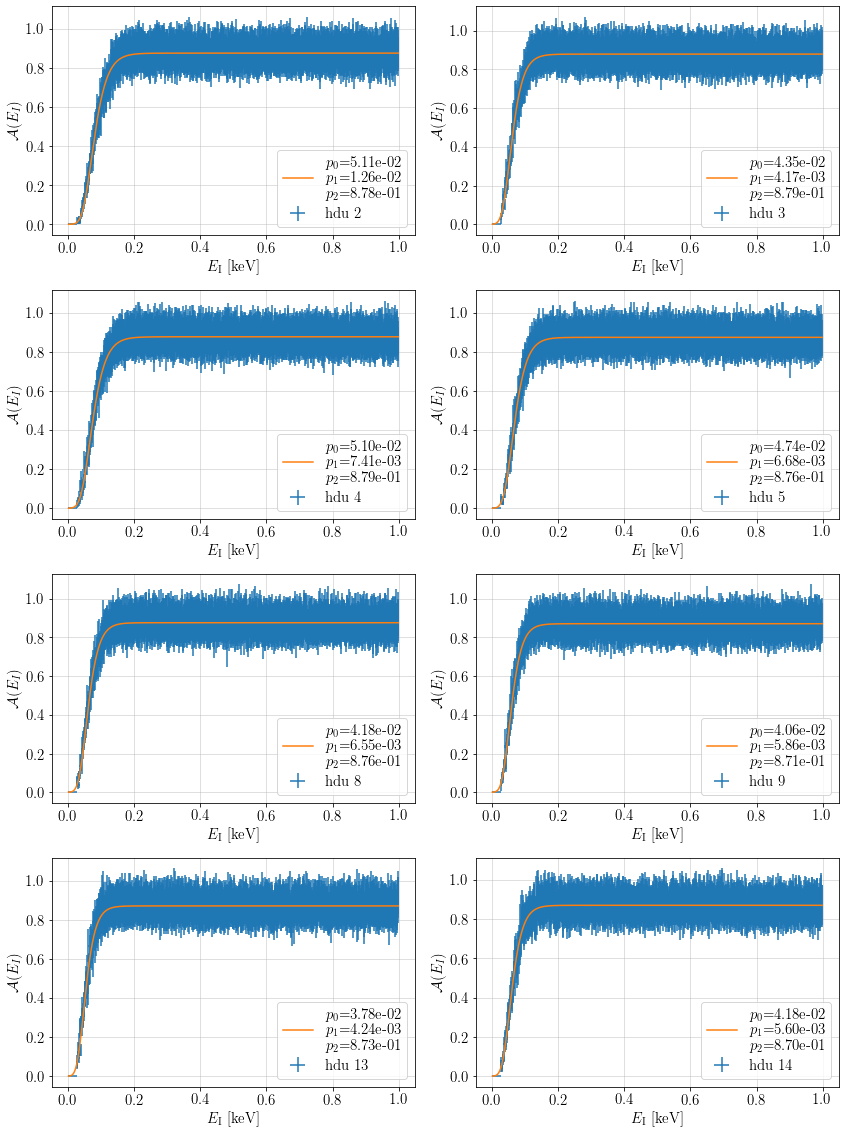

In [300]:
Acceptance(E_I, run2019.on_excl)[r"$\mathcal{A}(E_I)$"].curve_fit(
    x = r"$E_{\rm I}$", 
    z = "hdu", 
    func = tanhFit,
    p0 = [10,10,10]
).errorbar(x=r"$E_{\rm I}$", z="hdu", cols_wrap=2);

In [301]:
def A_fit( E_I, period, func, p0 ):
    a = Acceptance(E_I, period)[r"$\mathcal{A}(E_I)$"].curve_fit(
        x = r"$E_{\rm I}$", 
        z = "hdu", 
        func = func,
        p0 = p0
    )
    fit = a.attrs["fit"]
    x = E_I.pint.magnitude
    b = [ fit.attrs["func"]( x, *fit.sel(hdu=sel).data ) for sel in fit["hdu"] ]
    return ia.xr.DataArray(
        b, 
        dims=["hdu", *E_I.dims],
        coords = {
            E_I.name: E_I,
            "hdu": a["hdu"]
        }
    )#.set_coords(E_I=E_I, hdu=a["hdu"])

ia.iprint(A_fit(E_I, run2019.on_excl, tanhFit, [10,10,10]));

<xarray.Dataset>
Dimensions:          (E: 997, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (E) float64 [keV] 0.002 0.003 0.004 ... 0.996 0.997 0.998
Dimensions without coordinates: E
Data variables:
    $dN/dE_{\rm I}$  (hdu, E) object [count/keV] 0.0+/-0 ... (1.41+/-0.12)e+05
<xarray.DataArray (hdu: 8, E: 999)>
array([[6.91464536e-05, 8.76953696e-05, 1.10811917e-04, ...,
        8.77809705e-01, 8.77809705e-01, 8.77809705e-01],
       [4.02694228e-04, 5.14016556e-04, 6.52661883e-04, ...,
        8.78761131e-01, 8.78761131e-01, 8.78761131e-01],
       [2.25911331e-04, 2.81135306e-04, 3.48531266e-04, ...,
        8.79242992e-01, 8.79242992e-01, 8.79242992e-01],
       ...,
       [2.38857633e-04, 3.13801299e-04, 4.09784595e-04, ...,
        8.70954114e-01, 8.70954114e-01, 8.70954114e-01],
       [3.48779500e-04, 4.63186621e-04, 6.10847135e-04, ...,
        8.72936781e-01, 8.72936781e-01, 8.72936781e-01],
       [2.65901632e-04, 3.45821885e

## acceptance rate

In [302]:
def AdR__dE_I(E_I, Q, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    a = A_fit( E_I, period, func, p0 )
    b = dR__dE_I(E_I, Q, flux_nu)
    ret = a*b
    ret.name = r"$\mathcal{A}dR/dE_I$"
#     print( ret )
    return ret

( AdR__dE_I(E_I, Q, reactor_flux, run2019.on_excl) ).errorbar(
    x = r"$E_{\rm I}$", 
    yunits = "count/keV/kg/day",
    z = "hdu", 
    fmt = "", 
    cols_wrap = 2,
    xlim = (0,1)
);

<xarray.Dataset>
Dimensions:          (E: 997, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (E) float64 [keV] 0.002 0.003 0.004 ... 0.996 0.997 0.998
Dimensions without coordinates: E
Data variables:
    $dN/dE_{\rm I}$  (hdu, E) object [count/keV] 0.0+/-0 ... (1.41+/-0.12)e+05


IndexError: list index out of range

<xarray.Dataset>
Dimensions:      (E: 999)
Coordinates:
    $E_{\rm I}$  (E) float64 [keV] 0.001 0.002 0.003 0.004 ... 0.997 0.998 0.999
  * E            (E) float64 0.001 0.002 0.003 0.004 ... 0.996 0.997 0.998 0.999
Data variables:
    Lindhard     (E) float64 [count/d/keV/kg] 1.706e+03 1.364e+03 ... 0.09184
    SarkisPRD    (E) float64 [count/d/keV/kg] 69.75 70.86 ... 0.02713 0.02697
    SarkisAN     (E) float64 [count/d/keV/kg] 970.3 3.558e+03 ... 0.02719
    Chavarria    (E) float64 [count/d/keV/kg] 392.5 193.9 ... 0.02499 0.02485
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


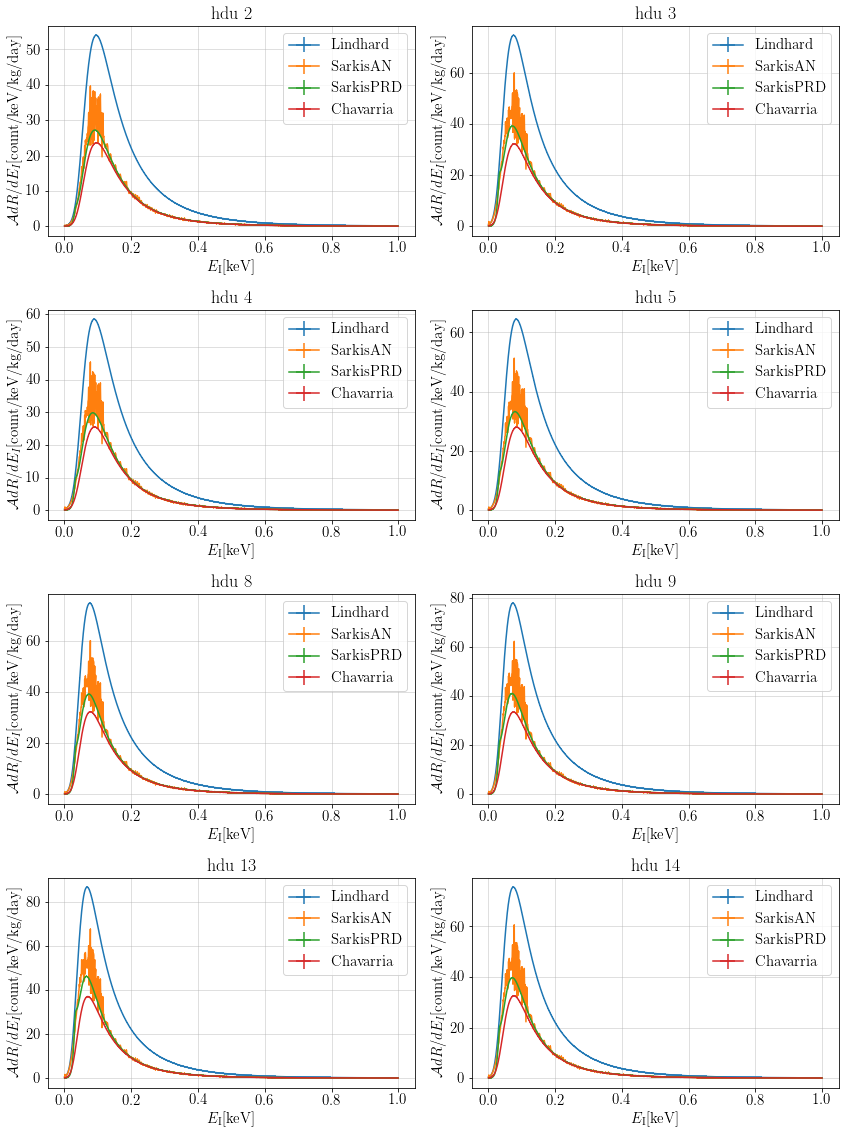

In [361]:
def AdR__dE_I(Q, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    e = Q[r"$E_{\rm I}$"]
    del e[r"$E_{\rm I}$"]
    del e["E"]
    a = A_fit( e, period, func, p0 )
    ret = a*Q
#     ret["name"] = r"$\mathcal{A}dR/dE_I$"
    return ret

quenchingFactors = quenchingFactors.pint.quantify()
print( quenchingFactors )
( AdR__dE_I(quenchingFactors, reactor_flux, run2019.on_excl) ).xerrorbar(
    x = r"$E_{\rm I}$", 
    ylabel = r"$\mathcal{A}dR/dE_I$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],
    yunits = "count/keV/kg/day",
    z = "hdu", 
    fmt = "", 
    cols_wrap = 2,
);

## energy dispersion

Multiple effects contribute for dispcrepancy between the measured energy and the ionization energy.
The main contribution comes from the reconstruction algorithm.
In order to account for it, the reconstructed energy is compared to the simulated energy in the matching catalogs.
Then the rate is corrected by convoluting the ionization energy with the dispersion kernel as
$$
\frac{d^3N_{\rm M} }{dEdMdt}(E_M) = 
\int_{E_{\rm min}}^{\infty} dE_I 
    \mathcal{A}(E_I) \frac{d^3N_{\rm I} }{dEdMdt}(E_I)
    G\left( E_M - E_I - \mu(E_I), \sigma(E_I) \right)
$$

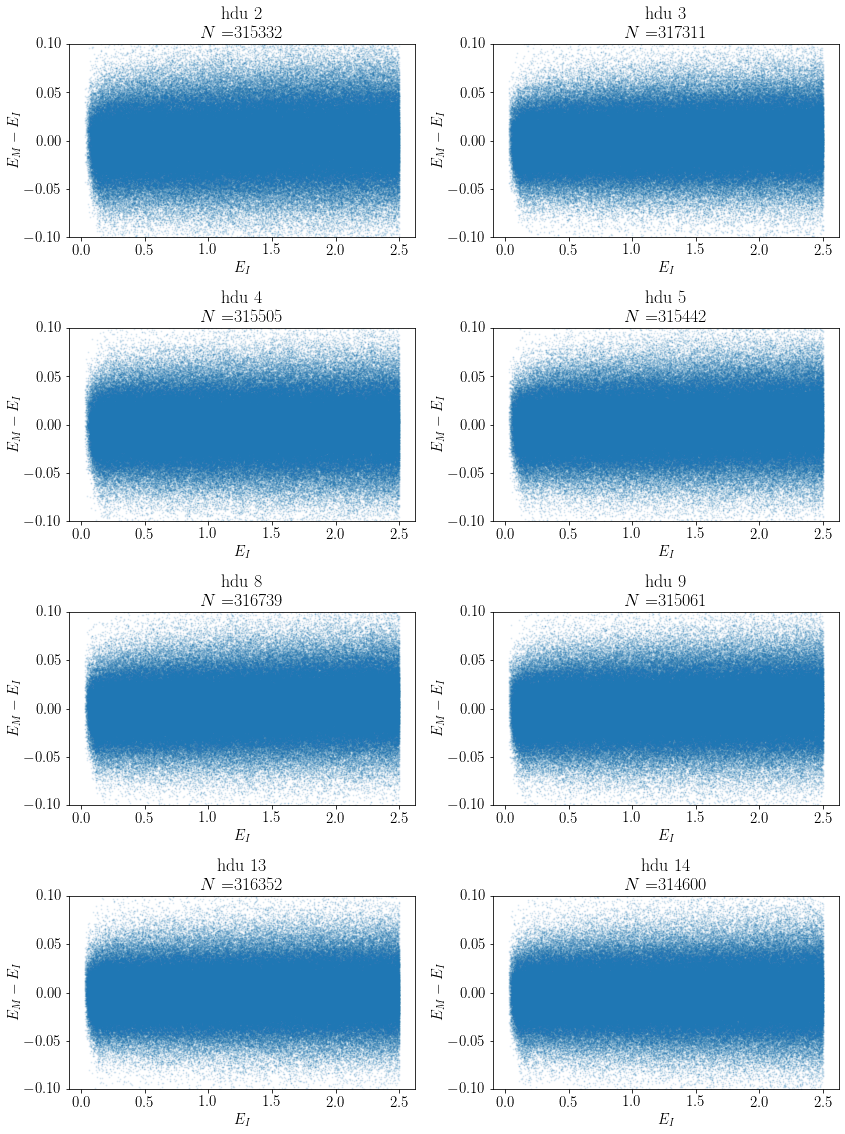

In [338]:
def dispersion_load( period, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {
            "E_I": ("oEnergy", "eV"),
            "E_M": ("E1/gain3Peaks", "keV"),
            "hdu": "ohdu"
        },
        cut = str(period*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )

    E_M = data["E_M"].pint.magnitude
    E_I = data["E_I"].pint.to('keV').pint.magnitude
    ohdu = data["hdu"]
    return dict(E_M=E_M, E_I=E_I, ohdu=ohdu)

def dispersion_per_ohdu( period, distSim=1.5 ):
    data = dispersion_load( period, distSim )
    return {
        ohdu: ia.np.vstack( (data["E_M"], data["E_I"]) )[:, data["ohdu"]==ohdu ] for ohdu in ia.np.unique(data["ohdu"])
    }, ["hdu", "kind", "E"]

def plot_dispersion( period, sel=slice(None, None), cols_wrap=2, distSim=1.5, func=lambda x, y: x ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    size = len(data)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    for i, (hdu, (e_M, e_I)) in enumerate( list(data.items())[sel] ):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        ax.scatter( e_I, func(e_I, e_M), s=1, alpha=.1 )
        ax.set_xlabel( r"$E_I$" )
        ax.set_ylabel( r"$E_M - E_I$" )
        ax.set_title( f"hdu {hdu}\n$N=${e_M.size}" )
        ax.set_ylim((-.1, .1))
    plt.tight_layout()
    return

delta = lambda x, y: (y-x)
plot_dispersion( run2019.on_excl, distSim=1.5, func=delta )

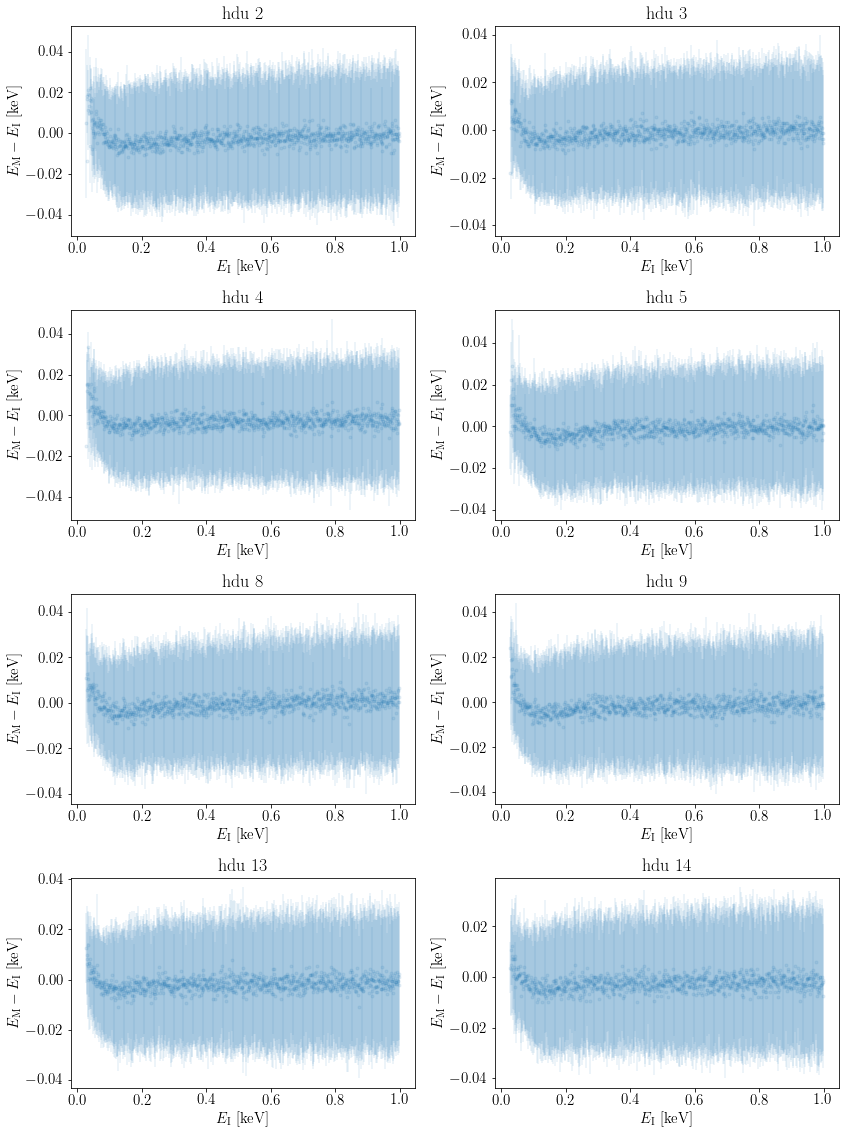

In [340]:
def dispersion_statistics( E_I, period, distSim=1.5 ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    stats = lambda x: ( x.mean(), x.std() )
    Ebins_keV = ((E_I[:-1] + E_I[1:])/2).pint.to("keV")
    Ebins_mag = Ebins_keV.data.magnitude
    compute = lambda x, y, bins, statistics: (
        ia.binned_statistic( y[abs(y - x)<.2], (x - y)[abs(y - x)<.2], statistic=statistics, bins=bins )[0]
    )
    means = [ compute( e_M, e_I, Ebins_mag, statistics='mean' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]
    stds = [ compute( e_M, e_I, Ebins_mag, statistics='std' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]

    return ia.xr.DataArray(
        ia.np.dstack((means, stds)) * ia.ureg.keV,
        dims = ["hdu", "E", "kind"],
        coords = {
            "kind": ["mean", "std"],
            "hdu": list(data.keys()),
            r"$E_{\rm I}$": E_I[1:-1]
        }
    )

def plot_dispersion_statistics( E_I, period, cols_wrap=2 ):
    dataarray = dispersion_statistics(E_I, period )
    hdus = dataarray["hdu"].data
    size = len(hdus)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    
    for i, hdu_data in enumerate( dataarray.sel(hdu=hdus)):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        means = hdu_data.sel(kind="mean")
        stds = hdu_data.sel(kind="std")
        ax.errorbar( 
            E_I.data.to("keV").magnitude[1:-1], 
            means.data.magnitude, 
            yerr = stds.data.magnitude, 
            fmt = ".", 
            alpha = .1 
        )
        ax.set_xlabel( E_I.name + f" [{E_I.pint.units}]" )
        ax.set_ylabel( r"$E_{\rm M} - E_{\rm I}$" + f" [{E_I.pint.units}]" )
        ax.set_title( f"hdu {hdus[i]}" )
    plt.tight_layout()
    return
        
plot_dispersion_statistics( E_I, run2019.on_excl )

### measured energy rate

a <xarray.Dataset>
Dimensions:      (E: 999, hdu: 8)
Coordinates:
  * E            (E) float64 0.001 0.002 0.003 0.004 ... 0.996 0.997 0.998 0.999
    $E_{\rm I}$  (E) float64 [keV] 0.001 0.002 0.003 0.004 ... 0.997 0.998 0.999
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Data variables:
    Lindhard     (hdu, E) float64 [count/d/keV/kg] 0.1179 0.1196 ... 0.07989
    SarkisPRD    (hdu, E) float64 [count/d/keV/kg] 0.004823 0.006214 ... 0.02346
    SarkisAN     (hdu, E) float64 [count/d/keV/kg] 0.0671 0.312 ... 0.02365
    Chavarria    (hdu, E) float64 [count/d/keV/kg] 0.02714 0.01701 ... 0.02161

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


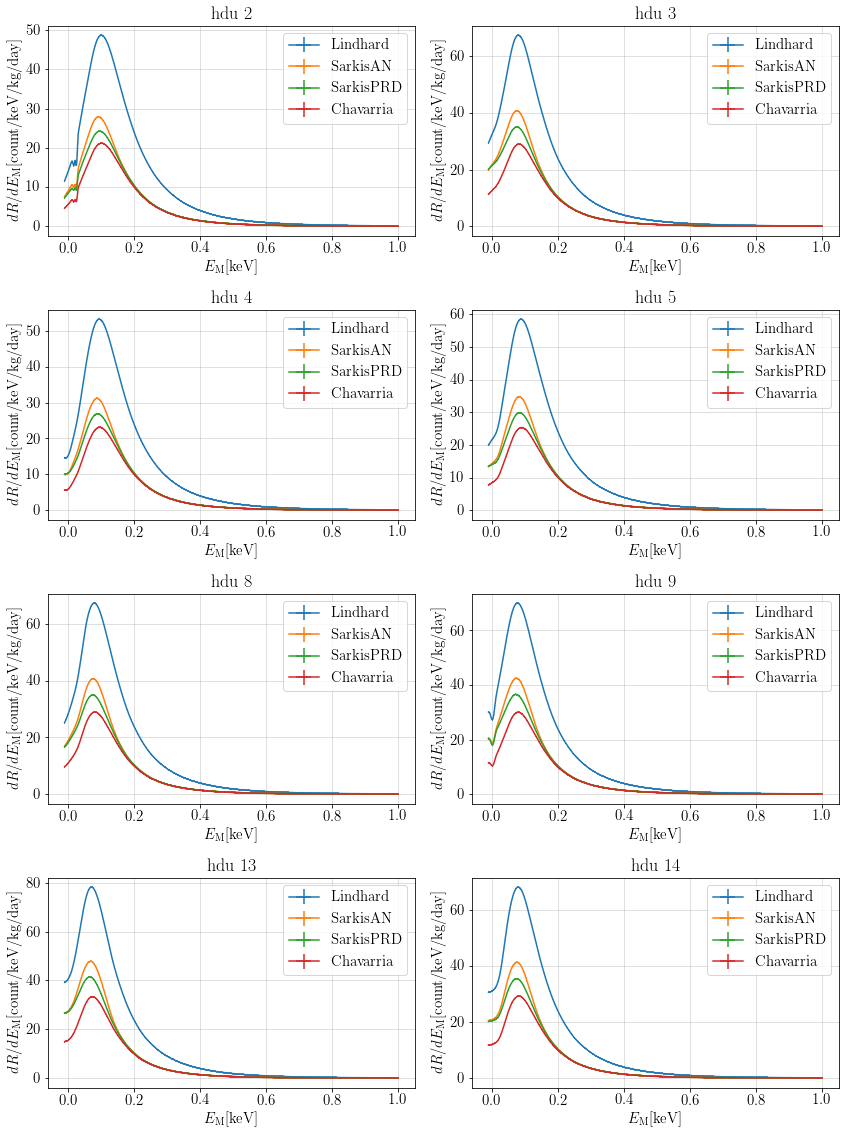

In [365]:
def dR__dE_M( E_M, Q, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    import scipy
#     print( Q )
    a = AdR__dE_I(Q, flux_nu, period, func=tanhFit, p0=[10,10,10])
#     print( "a", a )
#     print()
    
    E_I = Q[r"$E_{\rm I}$"].reset_coords(drop=True)
    del E_I["E"]
#     print( "E_I", E_I )
#     print()

    stats = dispersion_statistics(E_I, period)
#     print( "stats", stats )
#     print()
    diffs = E_M - E_I[1:-1] + stats.sel(kind="mean")
    sigma = stats.sel(kind="std")

#     print( sigma )
    sigma.data[ sigma.data == 0 ] = 100*ia.keV
    G = scipy.stats.norm.pdf( 
        diffs.data.magnitude,
        scale = sigma.data.magnitude.T[None,:,:]
    )
    G = ia.xr.DataArray(
        G,
        dims = ["Em", "E", "hdu"],
        coords = {
            "hdu": stats["hdu"],
            r"$E_{\rm M}$": E_M,
            r"$E_{\rm I}$": E_I[1:-1]
        }
    )
    G.data[ia.np.isnan(G.data)] = 0
#     a = a.where( sigma > 0 )
    ret = ( a[ {"E":slice(1,-1)} ]*G/ia.ureg.keV ).integrate(E_I.name)/( G/ia.ureg.keV ).integrate(E_I.name)
#     ret.name = r"$dR/dE_{\rm M}$"
    return ret

E_M = ia.xr.DataArray( name=r"$E_{\rm M}$", data=ia.arange(-.01, 1, .001) * ia.ureg.keV, dims = "Em" )
dR__dE_M( E_M, quenchingFactors, reactor_flux, run2019.on_excl ).xerrorbar(
    x = E_M.name, 
    z = "hdu", 
    ylabel = r"$dR/dE_{\rm M}$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],    
    yunits = "count/keV/kg/day", 
    fmt = "", 
    cols_wrap = 2,
#     xlim = (-.1,1),
);

## selection efficiency

In [366]:
def dNdata__dE_M( E_M, period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(period*run2019.excluded_ohdu),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

def dNsel__dE_M( E_M, period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
        ),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


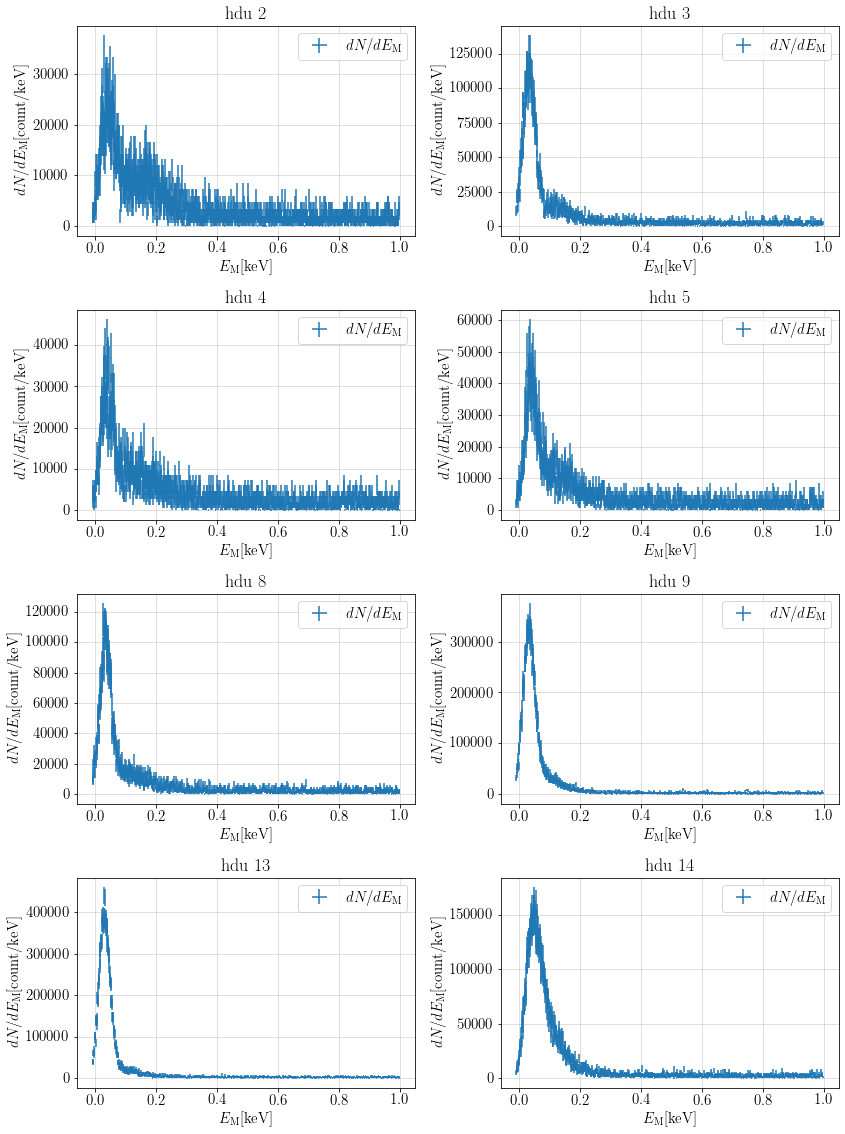

In [367]:
dNdata__dE_M( E_M, run2019.on_excl ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


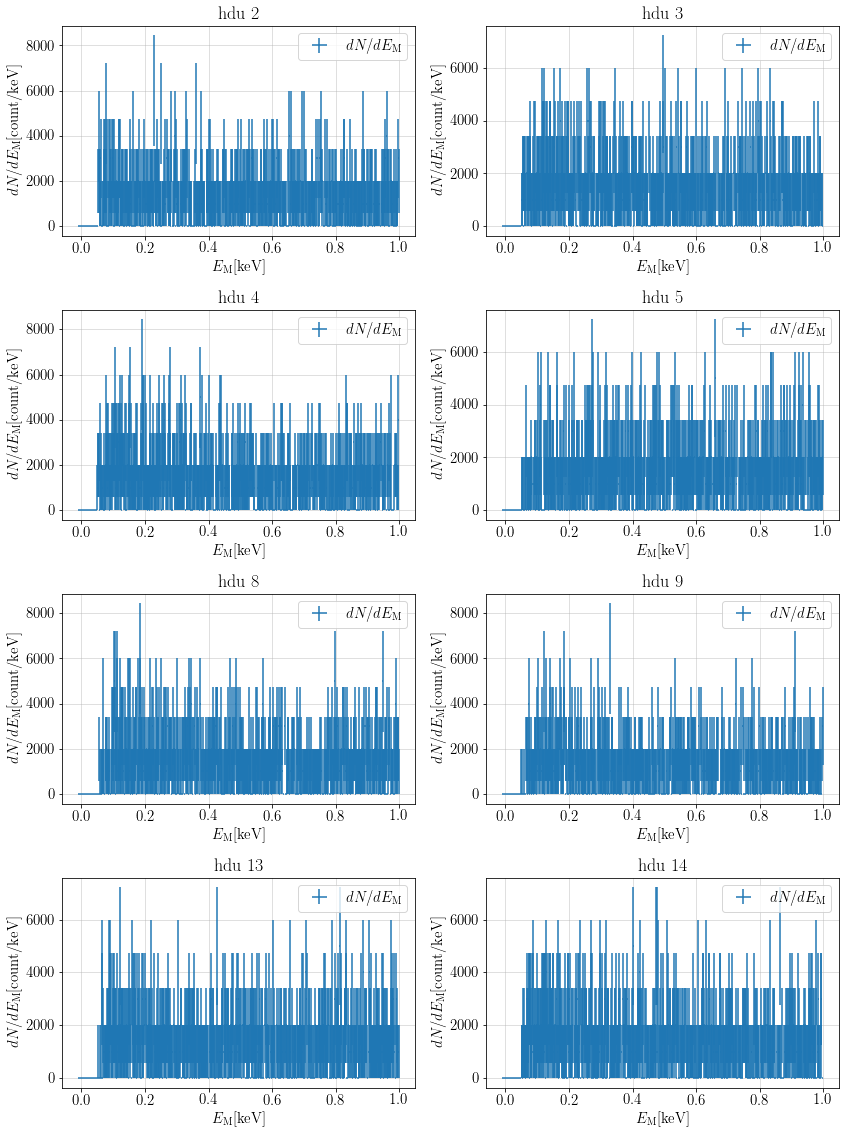

In [368]:
dNsel__dE_M( E_M, run2019.on_excl ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

In [369]:
def dNmatch__dE_M( E_M, cut, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

def dNmatchsel__dE_M( E_M, period, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'*f'distSim<={distSim}'
        ),
    )
    return data.xhistogram("hdu", centers=E_M, per_bin=True)

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


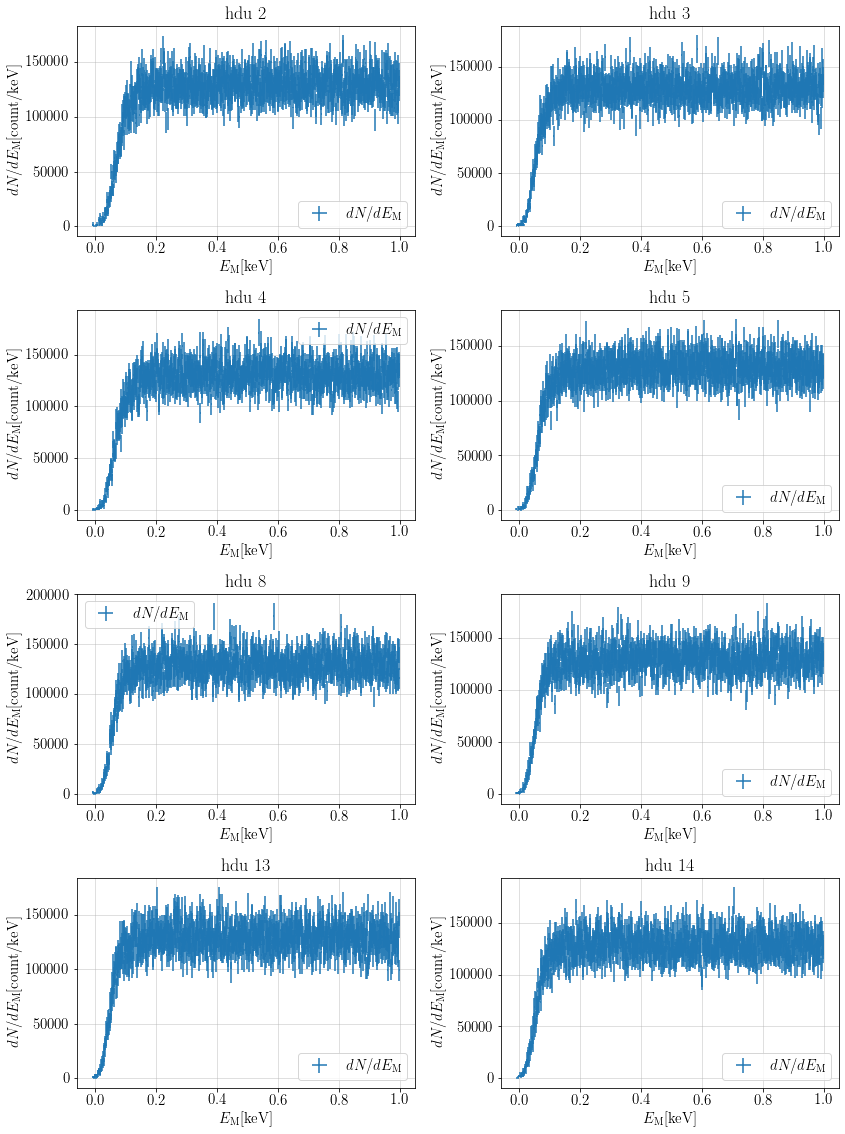

In [371]:
dNmatch__dE_M( E_M, run2019.on_excl ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


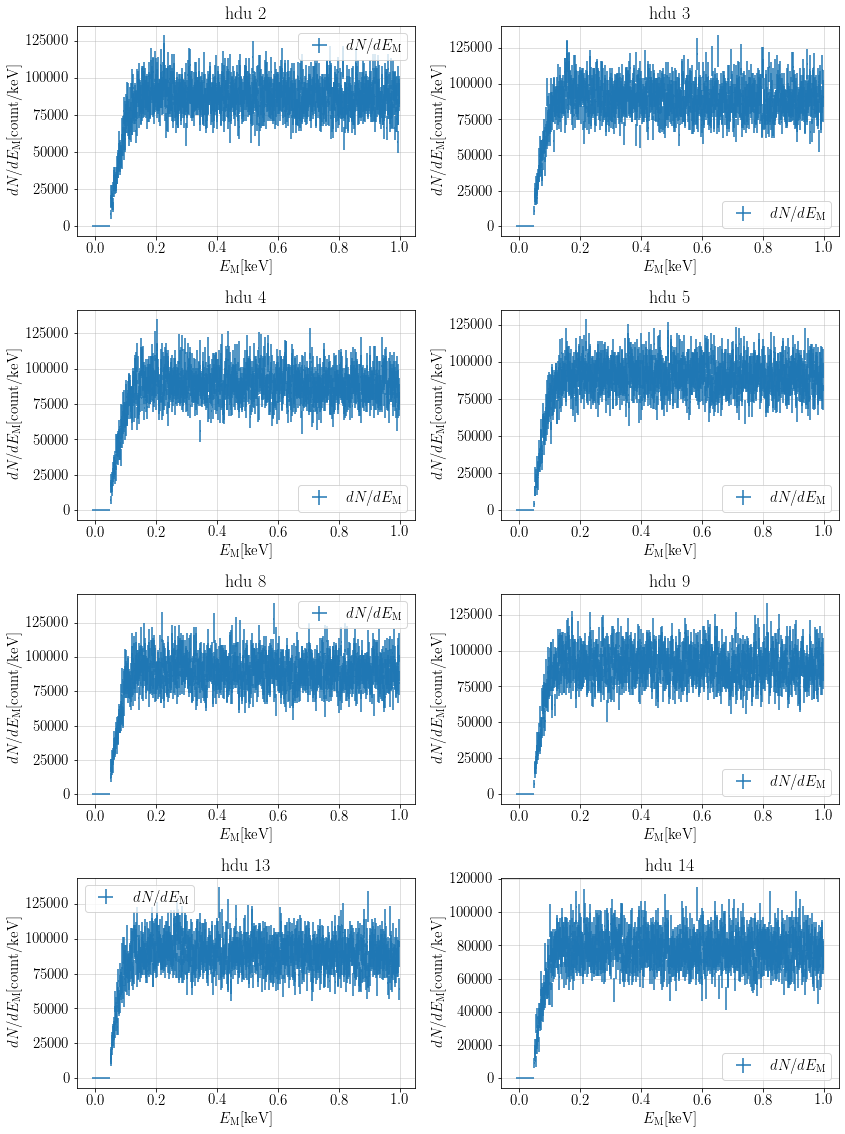

In [372]:
dNmatchsel__dE_M( E_M, run2019.on_excl ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

<xarray.Dataset>
Dimensions:             (Em: 1008, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] -0.009 -0.008 -0.007 ... 0.997 0.998
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.0+/-0 0.0 ... 0.61+/-0.09
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


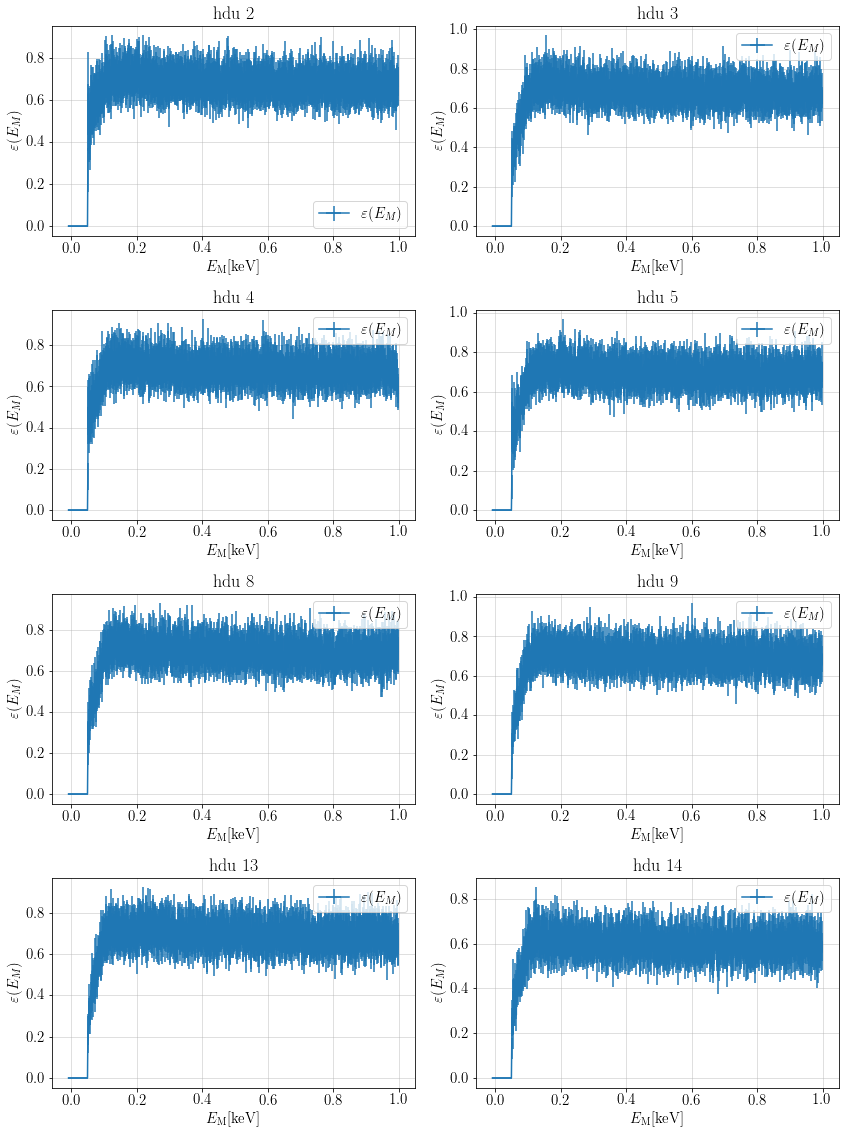

In [373]:
def Efficiency(E_M, cut):
    match = dNmatch__dE_M(E_M, cut)[r"$dN/dE_{\rm M}$"]
    matchSel = dNmatchsel__dE_M(E_M, cut)[r"$dN/dE_{\rm M}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {r"$\varepsilon(E_M)$": matchSel_where/match_where }
    )

ia.iprint( Efficiency(E_M, run2019.on_excl) ).xerrorbar(x=r"$E_{\rm M}$", y=r"$\varepsilon(E_M)$", z="hdu", cols_wrap=2);

## efficiency rate

a <xarray.Dataset>
Dimensions:      (E: 999, hdu: 8)
Coordinates:
  * E            (E) float64 0.001 0.002 0.003 0.004 ... 0.996 0.997 0.998 0.999
    $E_{\rm I}$  (E) float64 [keV] 0.001 0.002 0.003 0.004 ... 0.997 0.998 0.999
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Data variables:
    Lindhard     (hdu, E) float64 [count/d/keV/kg] 0.1179 0.1196 ... 0.07989
    SarkisPRD    (hdu, E) float64 [count/d/keV/kg] 0.004823 0.006214 ... 0.02346
    SarkisAN     (hdu, E) float64 [count/d/keV/kg] 0.0671 0.312 ... 0.02365
    Chavarria    (hdu, E) float64 [count/d/keV/kg] 0.02714 0.01701 ... 0.02161

ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar
ds_errorbar


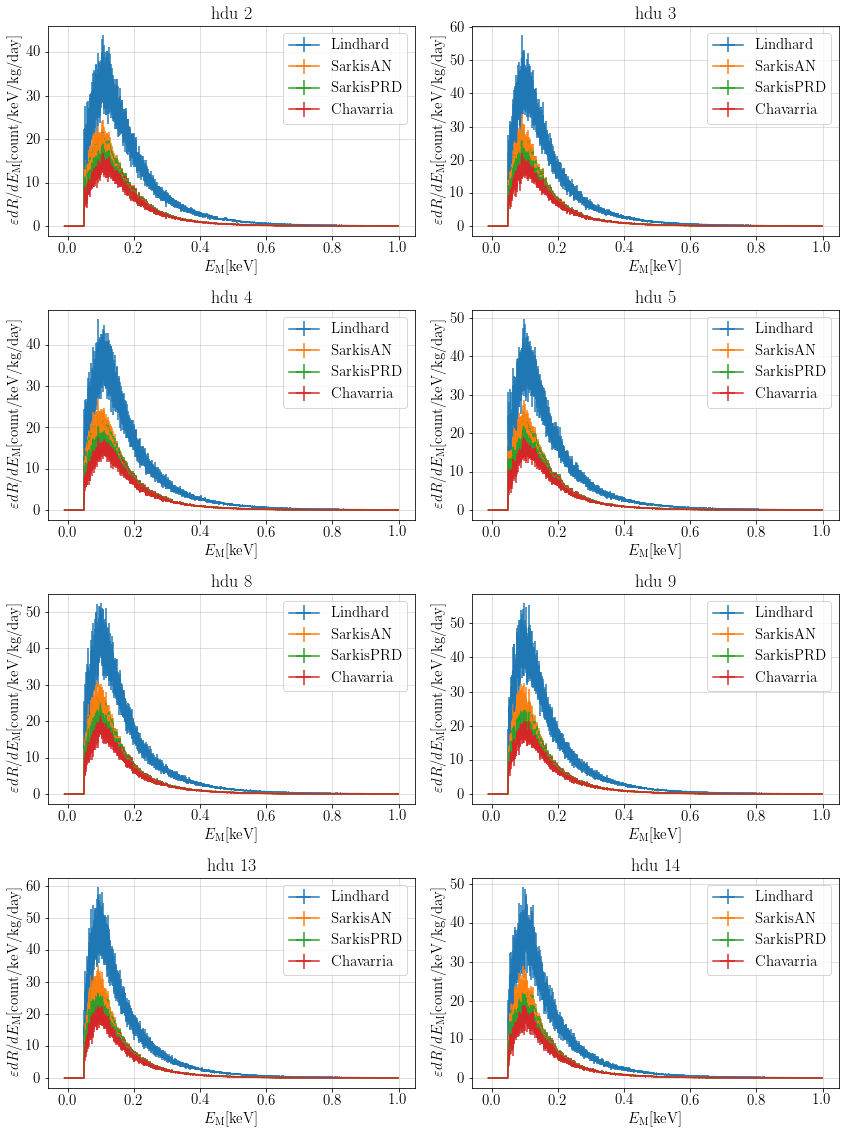

In [376]:
def edR__dE_M(E_M, Q, flux_nu, period):
    a = Efficiency(E_M, period)[r"$\varepsilon(E_M)$"]
    b = dR__dE_M( E_M, Q, flux_nu, period )[{"Em":slice(1,-1)}]
    ret = a*b
    ret[r"$E_{\rm M}$"] = E_M[1:-1]
#     ret.name = r"$\varepsilon d^3N/dE_{\rm M}dMdt$"
    return ret

finalRate = edR__dE_M(E_M, quenchingFactors, reactor_flux, run2019.on_excl)
finalRate.xerrorbar(
    x=r"$E_{\rm M}$", 
    yunits="count/keV/kg/day",
    ylabel = r"$\varepsilon dR/dE_{\rm M}$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],
    z="hdu", 
    fmt="", 
    cols_wrap=2,
#     xlim=(0,1)
);

## rebinned rate

In [597]:
_ = ia.arange(.05, .6, 0.13)*ia.ureg.keV
Ebins = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( Ebins )

<xarray.DataArray '$E$' (E: 5)>
<Quantity([0.05 0.18 0.31 0.44 0.57], 'kiloelectron_volt')>
Dimensions without coordinates: E


<xarray.Dataset>
Dimensions:      (E: 4, hdu: 8)
Coordinates:
    $E_{\rm M}$  (E) float64 [keV] 0.115 0.245 0.375 0.505
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: E
Data variables:
    Lindhard     (hdu, E) float64 [count/d/keV/kg] 27.33 11.62 ... 3.008 1.106
    SarkisPRD    (hdu, E) float64 [count/d/keV/kg] 13.29 4.858 ... 1.11 0.3768
    SarkisAN     (hdu, E) float64 [count/d/keV/kg] 14.67 4.865 ... 1.082 0.366
    Chavarria    (hdu, E) float64 [count/d/keV/kg] 11.79 4.702 ... 1.071 0.3553
<xarray.Dataset>
Dimensions:      (E: 4, hdu: 8)
Coordinates:
    $E_{\rm M}$  (E) float64 [keV] 0.115 0.245 0.375 0.505
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: E
Data variables:
    Lindhard     (hdu, E) float64 [count/d/keV/kg] 27.33 11.62 ... 3.008 1.106
    SarkisPRD    (hdu, E) float64 [count/d/keV/kg] 13.29 4.858 ... 1.11 0.3768
    SarkisAN     (hdu, E) float64 [count/d/keV/kg] 14.67 4.865 ... 1.082 0.366
    Chavar

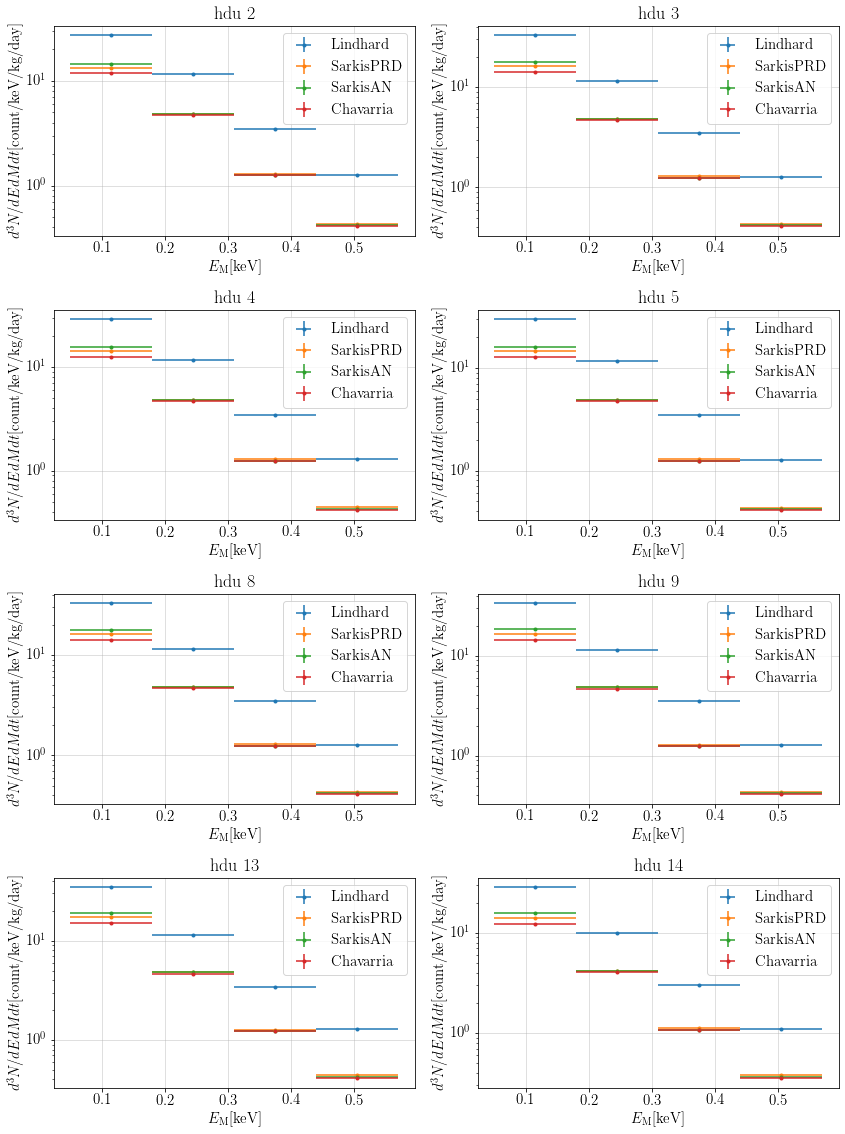

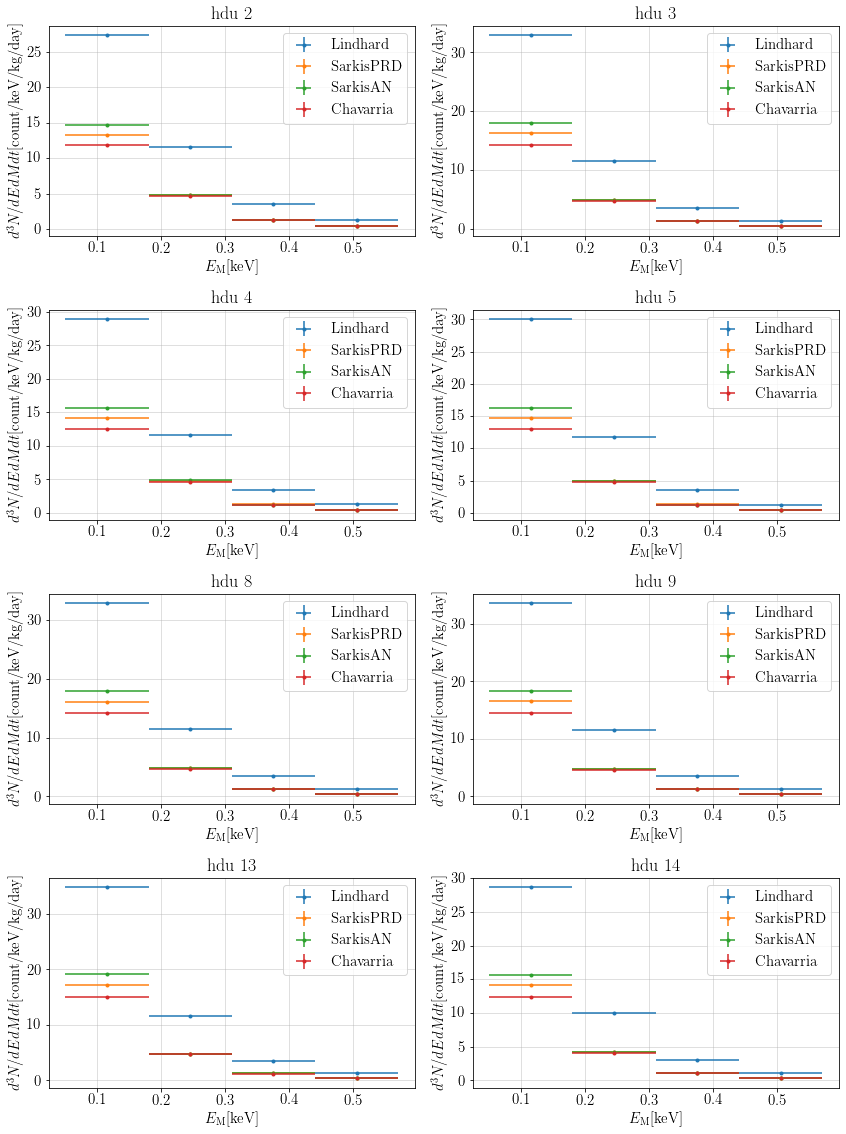

In [451]:
def rebin( rate, Ebins ):
    _EM = r"$E_{\rm M}$"
    ds = rate.set_coords(_EM)

    data = { 
        variable: ia.xr.DataArray(
            data = [ 
                ia.binned_statistic( 
                    datum.coords[r"$E_{\rm M}$"].pint.magnitude, 
                    ia.un.nominal_values(datum.pint.magnitude), 
                    statistic = "mean", 
                    bins = Ebins.pint.magnitude 
                )[0]
                for hdu in ds["hdu"] 
                for datum in [ds[variable].loc[{"hdu":hdu.data}]]
            ],
            dims = ("hdu", "E"),
            attrs = { "units": str(ds[variable].pint.units) }
        )
        for variable in ds.data_vars
    }
    ret = ia.xr.Dataset(
        data_vars = data,
        coords = { 
            r"$E_{\rm M}$": (Ebins[1:]+Ebins[:-1])/2,
            "hdu": ds["hdu"]
        }
    ).pint.quantify()

    return ret

ia.iprint( rebin( finalRate, Ebins ) ).xerrorbar(
    x = r"$E_{\rm M}$", 
    y = [ "Lindhard", "SarkisPRD", "SarkisAN", "Chavarria" ],
    yunits = "count/keV/kg/day",
    ylabel = r"$d^3N/dEdMdt$",
    z = "hdu", 
    fmt = ".", 
    cols_wrap = 2,
    yscale = "log"
);
ia.iprint( rebin( finalRate, Ebins ) ).xerrorbar(
    x = r"$E_{\rm M}$", 
    y = [ "Lindhard", "SarkisPRD", "SarkisAN", "Chavarria" ],
    yunits = "count/keV/kg/day",
    ylabel = r"$d^3N/dEdMdt$",
    z = "hdu", 
    fmt = ".", 
    cols_wrap = 2,
#     yscale = "log"
)

In [487]:
_ = rebin( finalRate, Ebins )

for variable in _.data_vars:
    print( variable )
    print( "keV\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in _[r"$E_{\rm M}$"] ]) )
    for hdu, row in zip(_["hdu"], _[variable]):
        print( f"{hdu.data}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in row ]) )
    print()

Lindhard
keV	0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065
2	27.33331	11.618483	3.5080797	1.2762568
3	32.931665	11.538617	3.4823331	1.2765038
4	28.91941	11.585624	3.4640215	1.2919028
5	30.035308	11.772256	3.4808882	1.2785841
8	32.914844	11.561314	3.4858995	1.280485
9	33.610892	11.531846	3.484342	1.2815212
13	34.827775	11.538615	3.4522034	1.2883775
14	28.680266	10.00512	3.008164	1.1056987

SarkisPRD
keV	0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065
2	13.288535	4.8577251	1.2977168	0.43542634
3	16.194686	4.8067972	1.2839266	0.43480457
4	14.122341	4.8353881	1.2797137	0.44062375
5	14.689444	4.9120107	1.2842812	0.43560303
8	16.160454	4.8173532	1.2851259	0.43605256
9	16.550493	4.8081504	1.285391	0.43669546
13	17.205152	4.8019298	1.2727954	0.43880047
14	14.118002	4.1718674	1.1097907	0.37682041

SarkisAN
keV	0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065
2	14.671899	4.8646743	1.265031	0.42291656
3	17.946776	4.8107348	1.2508221	0.42236494
4	15.605573	4.8412644	1.247063	0.4280269
5	16.240728

In [98]:
measured_rate = dR__dE_M( E_M, E_I, Q, reactor_flux, run2019.on_excl )

<xarray.DataArray (hdu: 8, Ei: 1998)>
<Quantity([[0.         0.         0.         ... 0.03477594 0.0358641  0.03134104]
 [0.         0.         0.         ... 0.0310124  0.02949765 0.03156438]
 [0.         0.         0.         ... 0.03169136 0.03296264 0.03142435]
 ...
 [0.         0.         0.         ... 0.03130589 0.02949612 0.03191959]
 [0.         0.         0.         ... 0.02891269 0.02614879 0.02819828]
 [0.         0.         0.         ... 0.03168159 0.02802823 0.02929706]], 'kiloelectron_volt')>
Coordinates:
    kind         <U4 'std'
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$  (Ei) float64 [keV] 0.001 0.002 0.003 ... 1.996 1.997 1.998
Dimensions without coordinates: Ei
<xarray.DataArray (Em: 2100, Ei: 1998, hdu: 8)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan, 

In [99]:
acceptance_rate = AdR__dE_I(E_I, Q, reactor_flux, run2019.on_excl)

In [100]:
ionization_rate = dR__dE_I( E_I, Q, reactor_flux )

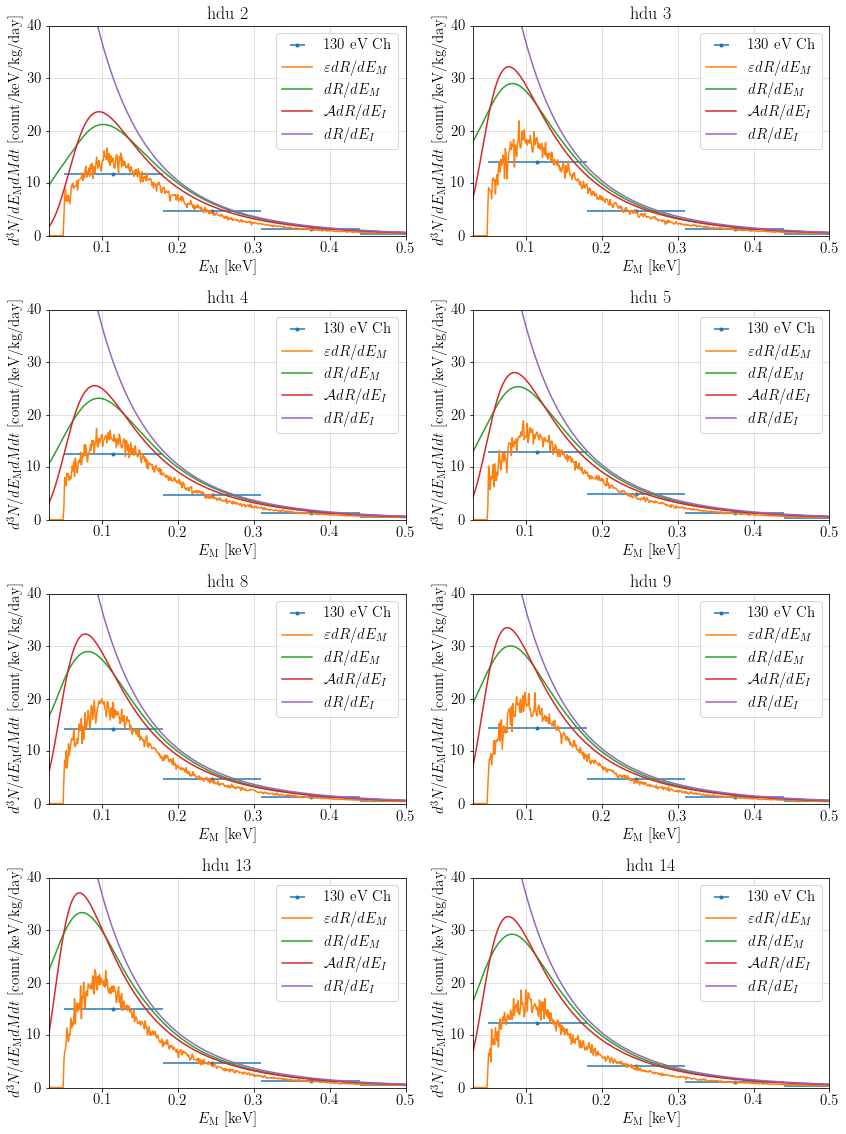

In [102]:
rebinRate = rebin( finalRate, Ebins )

z = "hdu"
size = rebinRate[z].size
cols_wrap = 2
nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
width, height = plt.rcParams["figure.figsize"]
fig = plt.figure( figsize = (width*ncols, height*nrows) )        
for i, hdu in enumerate(rebinRate["hdu"]):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title(f"hdu {hdu.data}")
    ax.set_xlabel(r"$E_{\rm M}$ [keV]")
    ax.set_ylabel(r"$d^3N/dE_{\rm M}dMdt$ [count/keV/kg/day]")
    ax.errorbar( 
        x = rebinRate["Ebins"] + .13/2, 
        y = rebinRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude, 
        xerr = .13/2,
        fmt = ".",
        label = f"130 eV Ch"
    )
    ax.errorbar( 
        x = finalRate[r"$E_{\rm M}$"].pint.magnitude, 
        y = ia.un.nominal_values( finalRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = fr"$\varepsilon dR/dE_M$"
    )
    ax.errorbar( 
        x = measured_rate[r"$E_{\rm M}$"].pint.magnitude, 
        y = ia.un.nominal_values( measured_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = fr"$dR/dE_M$"
    )
    ax.errorbar( 
        x = acceptance_rate[r"$E_{\rm I}$"].pint.magnitude, 
        y = ia.un.nominal_values( acceptance_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = r"$\mathcal{A}dR/dE_I$"
    )
    ax.errorbar( 
        x = ionization_rate[r"$E_{\rm I}$"].pint.magnitude, 
        y = ia.un.nominal_values( ionization_rate.data.to("count/keV/kg/day").magnitude ), 
        fmt = "",
        label = r"$dR/dE_I$"
    )
    ax.set_xlim((.03,.5))
    ax.set_ylim((0,40))
    ax.grid(True)
    plt.legend()
fig.tight_layout()

In [78]:
print( rebinRate )

<xarray.DataArray '$d^3N/dEdMdt$' (hdu: 8, Ebins: 7)>
<Quantity([[10.73010297  4.76898916  1.27920426  0.4121797   0.15354144  0.06223426
   0.02716707]
 [13.42005262  4.74954446  1.25434585  0.40953229  0.15233878  0.06268215
   0.02681393]
 [11.5679889   4.74476315  1.25584993  0.41350483  0.15445774  0.06300889
   0.02745817]
 [11.98512772  4.86449317  1.27046071  0.40933731  0.15453381  0.06292743
   0.02744575]
 [13.27864637  4.78269154  1.26027928  0.4132977   0.153172    0.06230824
   0.02684719]
 [13.56169941  4.77238932  1.25572319  0.41305667  0.15463204  0.06352894
   0.02718762]
 [14.22370045  4.73241511  1.24554147  0.41366158  0.15330984  0.06217809
   0.02728854]
 [11.67170297  4.11655301  1.08815546  0.35394578  0.13386424  0.05445528
   0.02378794]], 'count / day / kiloelectron_volt / kilogram')>
Coordinates:
  * hdu      (hdu) int32 2 3 4 5 8 9 13 14
  * Ebins    (Ebins) float64 0.05 0.18 0.31 0.44 0.57 0.7 0.83


In [ ]:
Lindhard = edR__dE_M(E_M, E_I, Q_Lindhard, flux_nu, run2019.on_excl)
rebin( Lindhard, Ebins ).errorbar(
    x=r"Ebins", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt=" ", 
    cols_wrap=2,
);

# Differential Rate

In [595]:
_ = ia.arange( .05-0.13/2, 10, 0.13 )*ia.ureg.keV
EbinsData = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( EbinsData )

<xarray.DataArray '$E$' (E: 78)>
<Quantity([-0.015  0.115  0.245  0.375  0.505  0.635  0.765  0.895  1.025  1.155
  1.285  1.415  1.545  1.675  1.805  1.935  2.065  2.195  2.325  2.455
  2.585  2.715  2.845  2.975  3.105  3.235  3.365  3.495  3.625  3.755
  3.885  4.015  4.145  4.275  4.405  4.535  4.665  4.795  4.925  5.055
  5.185  5.315  5.445  5.575  5.705  5.835  5.965  6.095  6.225  6.355
  6.485  6.615  6.745  6.875  7.005  7.135  7.265  7.395  7.525  7.655
  7.785  7.915  8.045  8.175  8.305  8.435  8.565  8.695  8.825  8.955
  9.085  9.215  9.345  9.475  9.605  9.735  9.865  9.995], 'kiloelectron_volt')>
Dimensions without coordinates: E


In [580]:
# rho = 2.33 *ia.ureg('g/cm^3') #kg/m^3
rho = 2.42 * ia.ureg('g/cm^3')
dM = rho * (15*ia.ureg('micrometer'))**2 * 675*ia.ureg("micrometer") * 4120**2
dM = dM.to('kg')
print( dM )


0.006238728539999999 kg


In [581]:
Ton = 735 * ia.ureg("hour").to("day")
Toff = 652 * ia.ureg("hour").to("day")

In [582]:
run2019.on_eff

((((((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522))) & ((runID!=6415) & (runID!=6475) & (runID!=6499) & (runID!=6926) & (runID!=6927) & (runID!=6031) & (runID!=6093) & (runID!=6096) & (runID!=6139) & (runID!=7074) & (runID!=7222) & (runID!=7226) & (runID!=7374))) & ((xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0))) & ((sizell<.95) & (sizell>0))) & ((E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50))

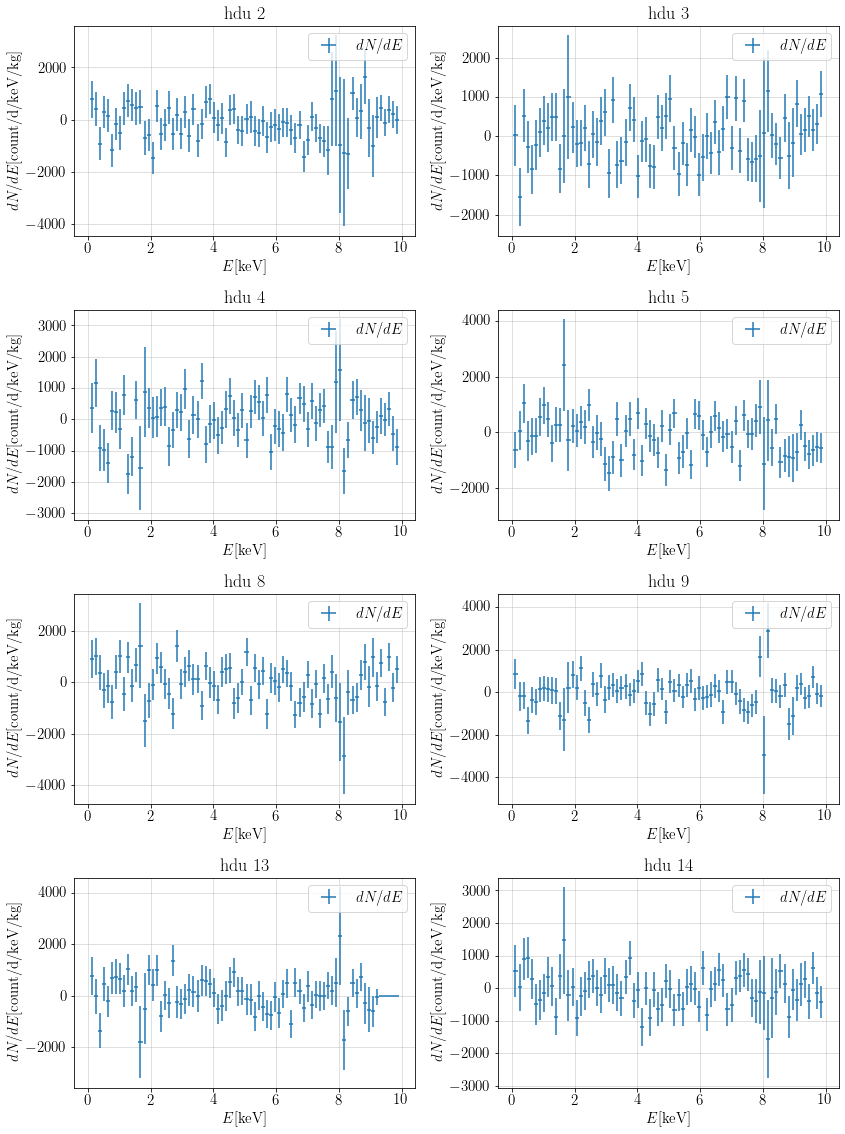

In [596]:
diffRate = (
    dNsel__dE_M( EbinsData, run2019.on_eff )/dM/Ton - dNsel__dE_M( EbinsData, run2019.off_eff )/dM/Toff
)
diffRate.xerrorbar( 
    x = r"$E$", 
    y = r"$dN/dE$", 
    z = "hdu", 
    fmt = " "
)
# print(diffRate)

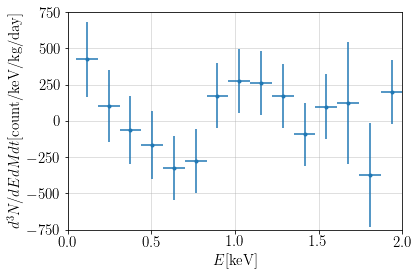

In [593]:
std_devs = ia.xr.apply_ufunc( ia.un.std_devs, diffRate[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
weights = 1./std_devs**2

meanRate = (
    ( diffRate[r"$dN/dE$"] * weights ).sum("hdu")/weights.sum("hdu") 
)

plt.errorbar( 
    meanRate[r"$E$"].pint.magnitude, 
    ia.un.nominal_values(meanRate.data.magnitude),
    xerr = .065,
    yerr = ia.un.std_devs(meanRate.data.magnitude),
    fmt = ".",
)
plt.xlabel(r"$E$[keV]")
plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
plt.ylim((-750,750))
plt.xlim((0,2))
plt.grid(True);

keV		0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065
Lindhard	31.174734	11.39891	3.416966	1.257764
SarkisPRD	15.297696	4.7535549	1.2609635	0.42863372
SarkisAN	16.958468	4.7581474	1.228644	0.41634299
Chavarria	13.430166	4.6042537	1.2168632	0.40416964
ON─OFF 90%CL	845.87624	508.72387	327.04761	213.37676


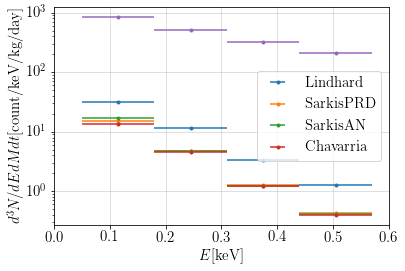

In [620]:
expected = rebin( finalRate, Ebins )
meanExpected = (
    ( expected * weights[{"E":slice(0,4)}] ).sum("hdu")/weights[{"E":slice(0,4)}].sum("hdu")
)

onSidedCL = ia.un.nominal_values(meanRate.data.magnitude) + 1.64 * ia.un.std_devs(meanRate.data.magnitude)
for variable in meanExpected.data_vars:
    plt.errorbar(
        meanExpected[r"$E$"].pint.magnitude,
        meanExpected[variable].pint.magnitude,
        xerr = .065,
#         yerr = 0,
        fmt = ".",
        label = variable
    )
plt.errorbar( 
    meanRate[r"$E$"].pint.magnitude[:4], 
    onSidedCL[:4],
    xerr = .065,
    fmt = ".",
)
plt.xlabel(r"$E$[keV]")
plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
# plt.ylim((-750,750))
plt.xlim((0,.6))
plt.yscale("log")
plt.grid(True)
plt.legend();

print( "keV\t\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in meanExpected[r"$E$"] ]) )
for variable in meanExpected.data_vars:
    print( f"{variable}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in meanExpected[variable] ]) )
print(f"ON─OFF 90%CL\t" + "\t".join([ f"{col:.8}" for col in onSidedCL[:4] ]) )

## runID selection

In [621]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.on_excl*run2019.excluded_ohdu )
)
on_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( on_dataset_grouped )

dims [8, 735]
[[   2 6032]
 [   3 6032]
 [   4 6032]
 ...
 [   9 7521]
 [  13 7521]
 [  14 7521]]
combinations (5880, 2)
$\sigma_{\rm raw}$
$\lambda_{\rm raw}$
$\sigma_{\rm scn}$
$\lambda_{\rm scn}$
<xarray.Dataset>
Dimensions:              (hdu: 8, runID: 735)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
  * runID                (runID) int32 6032 6033 6034 6035 ... 7519 7520 7521
Data variables:
    $\sigma_{\rm raw}$   (runID, hdu) float32 13.31 13.99 13.2 ... 13.58 12.69
    $\lambda_{\rm raw}$  (runID, hdu) float32 0.2667 0.2844 ... 0.2911 0.2615
    $\sigma_{\rm scn}$   (runID, hdu) float32 1.986 1.685 1.861 ... 1.572 1.665
    $\lambda_{\rm scn}$  (runID, hdu) float32 0.04396 0.04026 ... 0.02977


In [622]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.off_excl*run2019.excluded_ohdu )
)
off_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( off_dataset_grouped )

dims [8, 652]
[[   2 6227]
 [   3 6227]
 [   4 6227]
 ...
 [   9 6974]
 [  13 6974]
 [  14 6974]]
combinations (5216, 2)
$\sigma_{\rm raw}$
$\lambda_{\rm raw}$
$\sigma_{\rm scn}$
$\lambda_{\rm scn}$
<xarray.Dataset>
Dimensions:              (hdu: 8, runID: 652)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
  * runID                (runID) int32 6227 6228 6229 6230 ... 6972 6973 6974
Data variables:
    $\sigma_{\rm raw}$   (runID, hdu) float32 13.71 14.36 13.51 ... 13.68 12.99
    $\lambda_{\rm raw}$  (runID, hdu) float32 0.2586 0.2888 ... 0.288 0.2535
    $\sigma_{\rm scn}$   (runID, hdu) float32 1.997 1.694 1.873 ... 1.567 1.7
    $\lambda_{\rm scn}$  (runID, hdu) float32 0.04168 0.03634 ... 0.02901


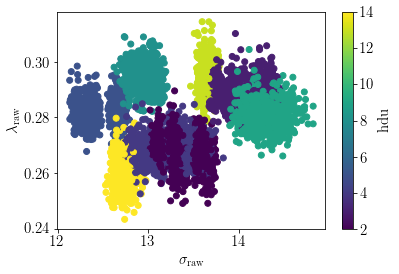

In [623]:
on_dataset_grouped.plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

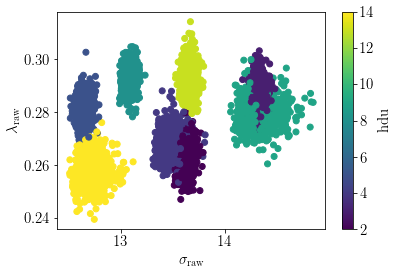

In [624]:
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

<xarray.Dataset>
Dimensions:              (hdu: 8)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
Data variables:
    $\sigma_{\rm raw}$   (hdu) object 13.43+/-0.19 14.09+/-0.21 ... 12.74+/-0.07
    $\lambda_{\rm raw}$  (hdu) object 0.267+/-0.006 ... 0.260+/-0.005
    $\sigma_{\rm scn}$   (hdu) object 1.99+/-0.10 1.69+/-0.06 ... 1.66+/-0.11
    $\lambda_{\rm scn}$  (hdu) object 0.0449+/-0.0034 ... 0.0296+/-0.0027


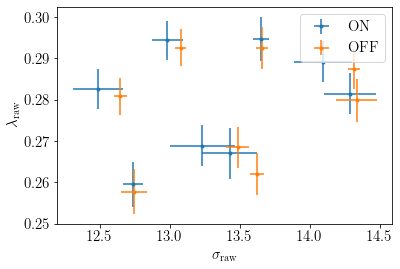

In [633]:
%autoreload 2
import iarray as ia
import matplotlib.pyplot as plt

_on = on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID")
_off = off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID")
print( _on )
plt.errorbar(
    ia.un.nominal_values(_on[r"$\sigma_{\rm raw}$"]),
    ia.un.nominal_values(_on[r"$\lambda_{\rm raw}$"]),
    xerr = ia.un.std_devs(_on[r"$\sigma_{\rm raw}$"]),
    yerr = ia.un.std_devs(_on[r"$\lambda_{\rm raw}$"]),
    fmt = ".",
    label = "ON"
)
plt.errorbar(
    ia.un.nominal_values(_off[r"$\sigma_{\rm raw}$"]),
    ia.un.nominal_values(_off[r"$\lambda_{\rm raw}$"]),
    xerr = ia.un.std_devs(_off[r"$\sigma_{\rm raw}$"]),
    yerr = ia.un.std_devs(_off[r"$\lambda_{\rm raw}$"]),
    fmt = ".",
    label = "OFF"
)
plt.xlabel(r"$\sigma_{\rm raw}$")
plt.ylabel(r"$\lambda_{\rm raw}$")
plt.legend();

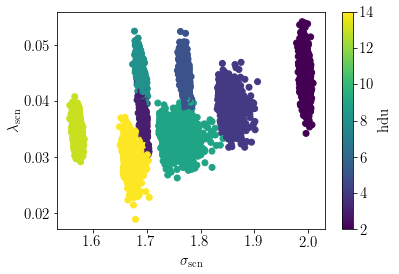

In [639]:
on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).plot.scatter(y=r"$\lambda_{\rm scn}$", x=r"$\sigma_{\rm scn}$", hue="hdu");

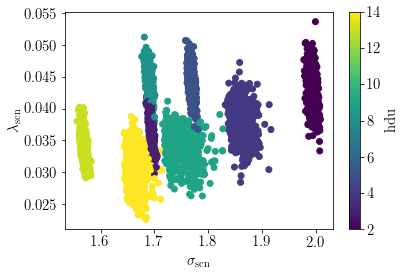

In [641]:
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).plot.scatter(y=r"$\lambda_{\rm scn}$", x=r"$\sigma_{\rm scn}$", hue="hdu");

<xarray.Dataset>
Dimensions:              (hdu: 8)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
Data variables:
    $\sigma_{\rm raw}$   (hdu) object 13.43+/-0.19 14.09+/-0.21 ... 12.74+/-0.07
    $\lambda_{\rm raw}$  (hdu) object 0.267+/-0.006 ... 0.260+/-0.005
    $\sigma_{\rm scn}$   (hdu) object 1.994+/-0.005 ... 1.671+/-0.009
    $\lambda_{\rm scn}$  (hdu) object 0.0449+/-0.0034 ... 0.0297+/-0.0027


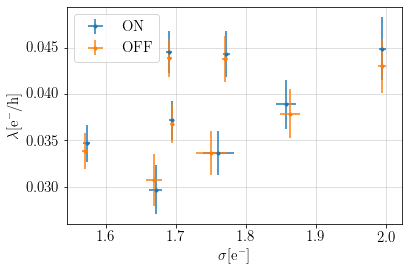

In [644]:
%autoreload 2
import iarray as ia
import matplotlib.pyplot as plt

_on = on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).stats("runID")
_off = off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).stats("runID")
print( _on )
plt.errorbar(
    ia.un.nominal_values(_on[r"$\sigma_{\rm scn}$"]),
    ia.un.nominal_values(_on[r"$\lambda_{\rm scn}$"]),
    xerr = ia.un.std_devs(_on[r"$\sigma_{\rm scn}$"]),
    yerr = ia.un.std_devs(_on[r"$\lambda_{\rm scn}$"]),
    fmt = ".",
    label = "ON"
)
plt.errorbar(
    ia.un.nominal_values(_off[r"$\sigma_{\rm scn}$"]),
    ia.un.nominal_values(_off[r"$\lambda_{\rm scn}$"]),
    xerr = ia.un.std_devs(_off[r"$\sigma_{\rm scn}$"]),
    yerr = ia.un.std_devs(_off[r"$\lambda_{\rm scn}$"]),
    fmt = ".",
    label = "OFF"
)
plt.xlabel(r"$\sigma$[e$^-$]")
plt.ylabel(r"$\lambda$[e$^-$/h]")
plt.grid(True)
plt.legend();